In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pyke.prf import SimpleKeplerPRF

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
prf = SimpleKeplerPRF(channel=16, shape=(11, 11), column=250, row=200)

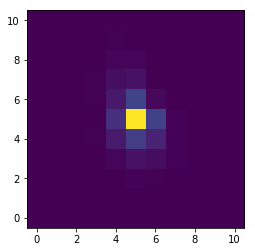

In [4]:
plt.imshow(prf(flux=1e4, center_col=255.5, center_row=205.5), origin='lower')

In [5]:
import numpy as np
from scipy import signal

In [6]:
cadences = np.arange(1000)

In [7]:
A = 1e4 + 1e2 * np.sin(2 * np.pi * np.linspace(0, 6, 1000)) + 300 * np.linspace(0, 1, 1000)
xc = 255.5 + 0.05 + .9*signal.sawtooth(np.linspace(0, 100, 1000))
yc = 205.5 + 0.05 + .9 - .9*signal.sawtooth(np.linspace(0, 100, 1000))

In [8]:
tpf = 1 + np.array([np.random.poisson(prf(flux=A[i], center_col=xc[i], center_row=yc[i]) + 3) for i in range(1000)], dtype=np.float64)
tpf_save = np.copy(tpf)

In [9]:
#tpf[:, 4, 3] = .9 * tpf[:, 4, 3]

In [10]:
#tpf[:, 5, 6] = 1.05 * tpf[:, 5, 6]

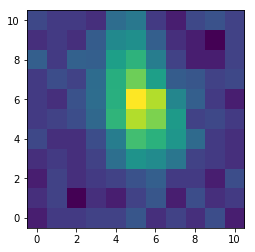

In [11]:
plt.imshow(np.log(tpf[100]), origin='lower', interpolation='nearest')

In [12]:
true_detector = np.ones(tpf.shape[1:])

In [13]:
#true_detector[4, 3] = .9 * true_detector[4, 3]
#true_detector[5, 6] = 1.05 * true_detector[5, 6]

In [14]:
true_detector.shape

(11, 11)

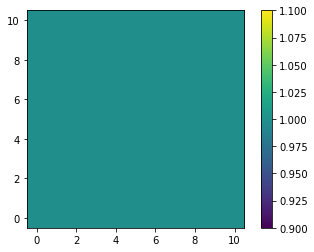

In [15]:
plt.imshow(true_detector, origin='lower')
plt.colorbar()

In [16]:
lc = np.sum(tpf, axis=(1,2))

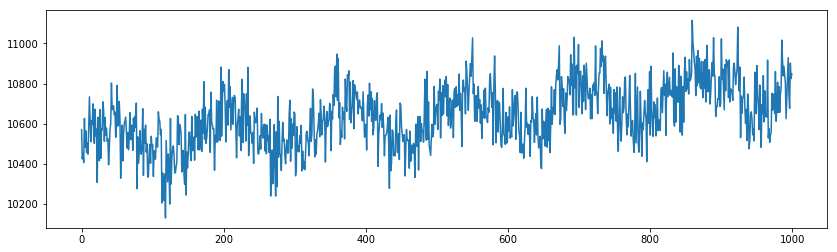

In [17]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, lc)

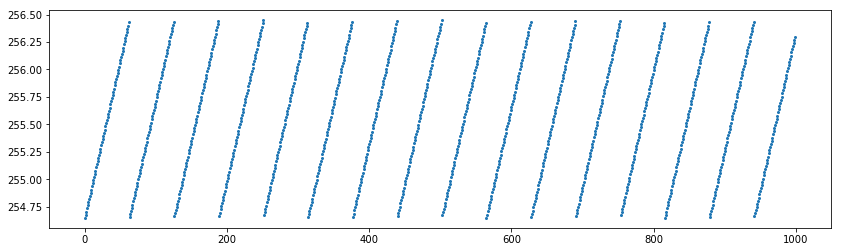

In [18]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xc, 'o', markersize=2)

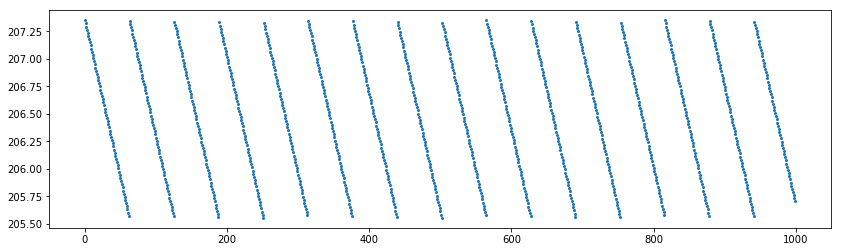

In [19]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, yc, 'o', markersize=2)

In [20]:
from pyke.prf import PRFPhotometry

In [21]:
from oktopus.models import IntegratedSymmetricGaussian2D

In [22]:
from oktopus.prior import UniformPrior

In [23]:
y, x = np.indices(prf.shape) + 0.5

In [24]:
x = x + 250
y = y + 200

In [25]:
psf = IntegratedSymmetricGaussian2D(x, y)

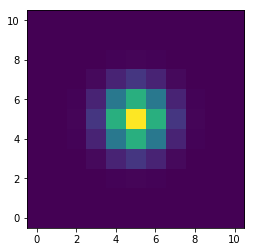

In [26]:
plt.imshow(psf(1000, 255.5, 205.5, 1), origin='lower', interpolation='nearest')

In [27]:
prior = UniformPrior(lb=[5e3, 252.5, 202.5, .25],
                     ub=[15e3, 258.5, 208.5, 1.25])

In [28]:
phot_poisson = PRFPhotometry(scene_model=psf, prior=prior)

In [29]:
results_poisson = phot_poisson.fit(tpf_flux=tpf)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 1000/1000 [00:20<00:00, 48.12it/s]


In [30]:
flux = results_poisson[:, 0]
xcenter = results_poisson[:, 1]
ycenter = results_poisson[:, 2]
shape = results_poisson[:, 3]

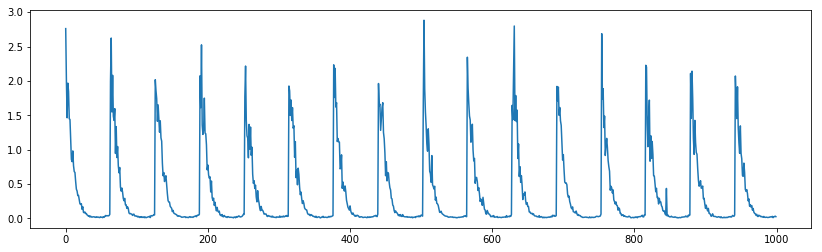

In [31]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, flux - lc)

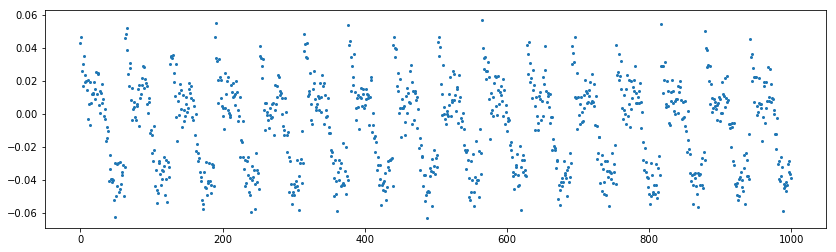

In [32]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xcenter - xc, 'o', markersize=2)

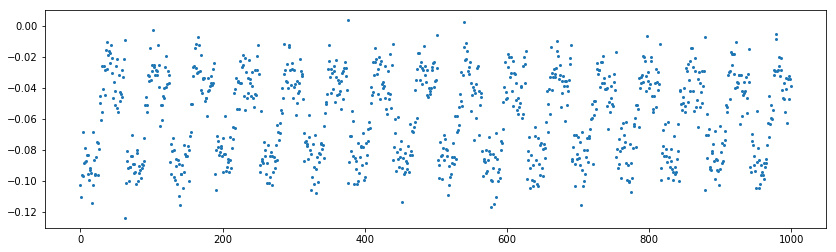

In [33]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, ycenter - yc, 'o', markersize=2)

In [34]:
import numpy as np

In [35]:
x = np.linspace(0, 10, 11)

In [36]:
y = np.linspace(0, 10, 11)

In [37]:
xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [38]:
from scipy.interpolate import RectBivariateSpline

In [39]:
tpf = np.log(tpf)

In [40]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]

In [41]:
super_tpf = np.array([interp[i](yp + (ycenter[i] - 205.5), xp + (xcenter[i] - 255.5)) for i in range(len(xc))])

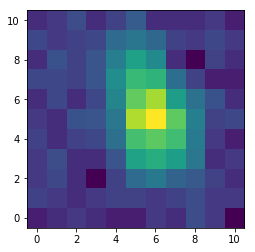

In [42]:
plt.imshow(tpf[-1], origin='lower', interpolation='nearest')

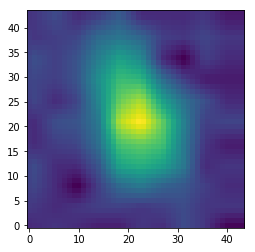

In [43]:
plt.imshow(super_tpf[-1], origin='lower', interpolation='nearest')

In [44]:
mean_super_tpf = np.mean(super_tpf, axis=0)

In [45]:
mean_super_tpf.shape

(44, 44)

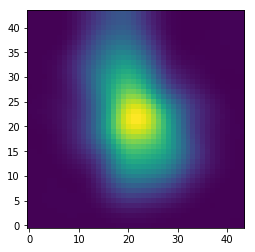

In [46]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')

In [47]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

In [48]:
np.sum(norm_super_tpf)

0.99999999999999989

In [49]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx)

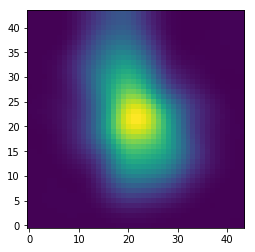

In [50]:
plt.imshow(model_prime(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [51]:
np.sum(model_prime(10, 0, 0, norm_super_tpf))

10.0

In [52]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))

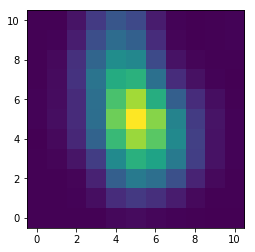

In [53]:
plt.imshow(model(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [54]:
np.sum(model(10, 0, 0, norm_super_tpf))

10.0

In [55]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s) + model(1, 0, 0, template_d) - self.data
        return np.sum(r * r * self.data)

In [56]:
detector = np.zeros((44, 44))

In [57]:
from scipy.optimize import minimize

In [58]:
from tqdm import tqdm

In [59]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(np.log(1e4), 0, 0), args=(norm_super_tpf, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [01:00<00:00, 14.51it/s]


In [60]:
results = np.array(results)

In [83]:
center_y = results[:, 1]

In [84]:
center_x = results[:, 2]

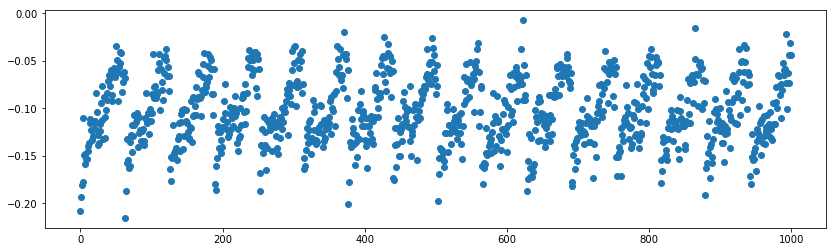

In [88]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), center_y - (yc - 205.5), 'o')

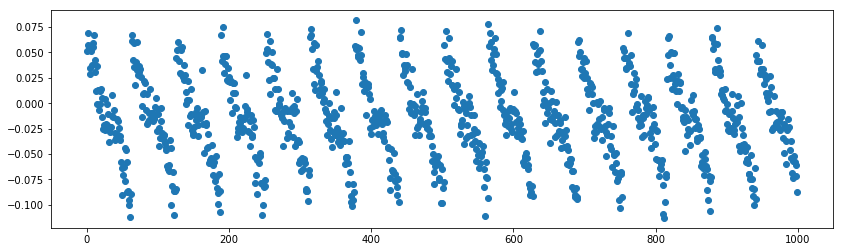

In [89]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), center_x - (xc - 255.5), 'o')

In [61]:
results.shape

(1000, 3)

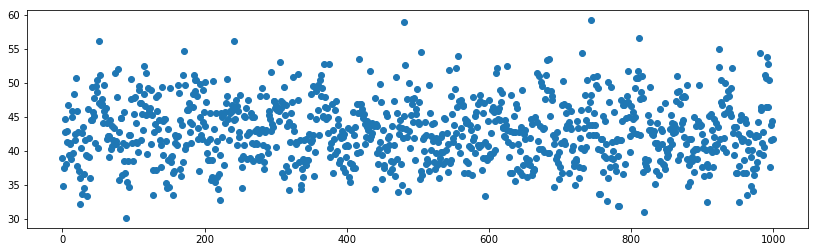

In [62]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [67]:
results[-1]

array([  2.89117328e+02,   1.58748977e-01,   7.10621822e-01])

In [68]:
np.sum(model(*results[-1], norm_super_tpf))

288.27371680017552

In [70]:
np.sum(tpf[-1])

268.75487667282761

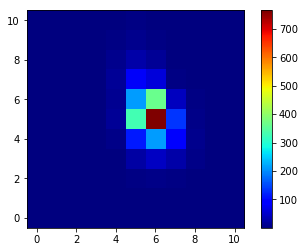

In [72]:
model_ = model(*results[-1], norm_super_tpf)
model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(np.exp(model_) - np.exp(model_test), origin='lower', interpolation='nearest', cmap='jet')
plt.colorbar()

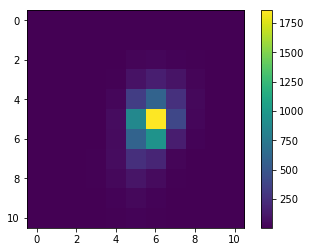

In [64]:
plt.imshow(np.exp(model_), interpolation='nearest')
plt.colorbar()

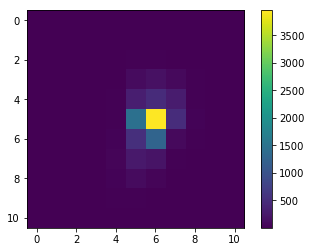

In [66]:
plt.imshow(np.exp(tpf[-1]), interpolation='nearest')
plt.colorbar()

In [85]:
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [86]:
gds = norm_super_tpf

In [115]:
models = [model(*results[i], gds) for i in range(1000)]
interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]

In [88]:
dlnlike_ds = 2 * np.array([results[i, 0] * interps[i](yp - results[i, 1], xp - results[i, 2]) for i in range(1000)])

In [89]:
dlnlike_ds.shape

(1000, 44, 44)

In [90]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

In [91]:
dlnlike_ds.shape

(44, 44)

In [92]:
dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])

In [93]:
dlnlike_dd = np.sum(dlnlike_dd, axis=0)

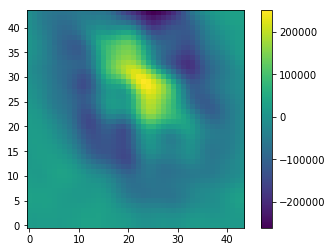

In [94]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

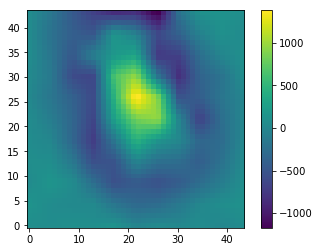

In [95]:
plt.imshow(-dlnlike_dd, origin='lower', interpolation='nearest')
plt.colorbar()

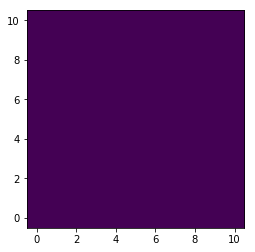

In [96]:
plt.imshow(true_detector, origin='lower')

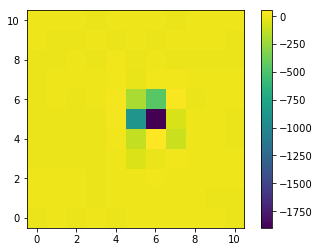

In [116]:
plt.imshow(np.exp(models[-2]) - np.exp(tpf[-2]), origin='lower')
plt.colorbar()

In [101]:
dlnlike_ds.shape

(44, 44)

In [102]:
gds = np.copy(norm_super_tpf)

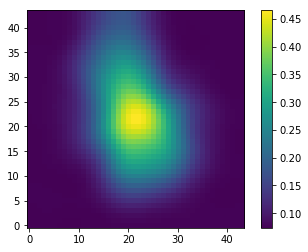

In [103]:
plt.imshow(results[0, 0] * gds, origin='lower', interpolation='nearest')
plt.colorbar()

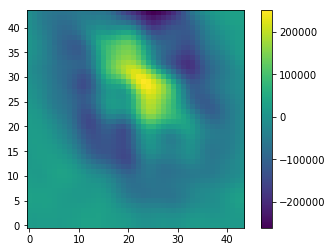

In [104]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [105]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-12
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 2000:
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
        dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [106]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-9
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
        dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

In [107]:
gdd=np.zeros((44, 44))

In [108]:
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))
#gds = gds / np.sum(gds)

27976.5135919
27971.0990036
27971.0990036
27965.1612306
27965.1612306
27958.651735
27958.651735
27951.5179005
27951.5179005
27943.7027812
27943.7027812
27935.1448566
27935.1448566
27925.777799
27925.777799
27915.5302608
27915.5302608
27904.3256936
27904.3256936
27892.08221
27892.08221
27878.7125045
27878.7125045
27864.1238523
27864.1238523
27848.218208
27848.218208
27830.8924334
27830.8924334
27812.0386838
27812.0386838
27791.544995
27791.544995
27769.2961129
27769.2961129
27745.1746214
27745.1746214
27719.062428
27719.062428
27690.8426795
27690.8426795
27660.4021881
27660.4021881
27627.6344611
27627.6344611
27592.4434391
27592.4434391
27554.7480617
27554.7480617
27514.4877932
27514.4877932
27471.6292609
27471.6292609
27426.1741761
27426.1741761
27378.1687344
27378.1687344
27327.7147272
27327.7147272
27274.9826423
27274.9826423
27220.2271007
27220.2271007
27163.8050833
27163.8050833
27106.1975575
27106.1975575
27048.0353535
27048.0353535
26990.1305054
26990.1305054
26933.5148175
26933.

In [100]:
gdd = gradient_descent_dd(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))

22761.8633478
22761.8622905


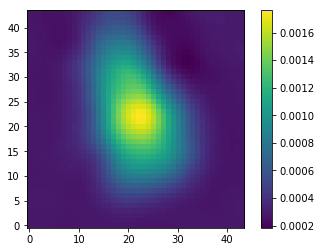

In [109]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

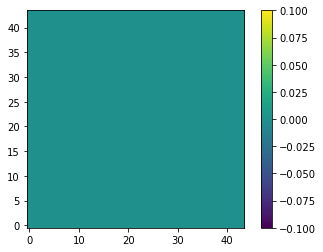

In [110]:
plt.imshow(gdd, origin='lower', interpolation='nearest')
plt.colorbar()

In [111]:
np.sum(gds)

0.98038881646941189

In [112]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

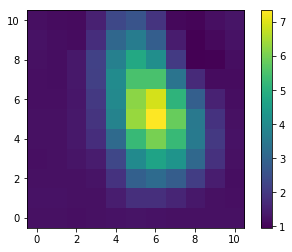

In [113]:
n=-1
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) + model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [114]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    print(sol)
    results.append(sol.x)
    lnlike.append(sol.fun)

  0%|          | 5/1000 [00:00<00:51, 19.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.102280312826565
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 273.67862303,    1.56911883,   -0.82464639])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.178268342597704
 message: 'Optimization terminated successfully.'
    nfev: 89
     nit: 3
  status: 0
 success: True
       x: array([ 275.4480014 ,    1.58362369,   -0.78663302])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.920530332377755
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 269.73349786,    1.47641442,   -0.744262  ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.139972227559511
 message: 'Optimization terminated successfully.'
    nfe

  1%|          | 10/1000 [00:00<00:51, 19.25it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.18660231553525
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 3
  status: 0
 success: True
       x: array([ 276.57728747,    1.43218355,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.03002947055576
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.19356564,    1.47092084,   -0.68565868])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.159488746554331
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 274.55217598,    1.44744401,   -0.641383  ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.670430048387136
 message: 'Optimization terminated successfully.'
    nfev

  2%|▏         | 15/1000 [00:00<00:49, 19.76it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.248313606630767
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 279.64242155,    1.36706197,   -0.5511236 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.19837725e-02,   1.87365912e-03,  -3.81652706e-04]])
     fun: 25.780101637162563
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.12345463,    1.33642942,   -0.52488948])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.63707911e-02,   1.40851927e-03,  -3.09677565e-04]])
     fun: 27.345871613775248
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: T

  2%|▏         | 20/1000 [00:01<00:49, 19.79it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.803995882877043
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 272.4432006 ,    1.19622427,   -0.43924501])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.125451081991766
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([ 273.32155731,    1.16279068,   -0.44052735])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.073982786082087
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 281.97355905,    1.15286474,   -0.35026346])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.409762380581547
 message: 'Optimization terminated successfully.'
    nf

  2%|▏         | 22/1000 [00:01<00:50, 19.18it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.73763799e-03,   2.13768872e-03,  -4.70993668e-04]])
     fun: 25.868400425399066
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 274.79227979,    1.06624382,   -0.28362485])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.52294439e-03,   1.88176689e-03,  -4.33687171e-04]])
     fun: 23.831464101228136
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.73888610e+02,   1.03408397e+00,  -2.67094178e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.109064823842846
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 2
  status: 0
 s

  3%|▎         | 27/1000 [00:01<00:55, 17.69it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.446300287684959
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 3
  status: 0
 success: True
       x: array([  2.78297138e+02,   9.30232407e-01,  -2.02885733e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.270630773518899
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([  2.78856469e+02,   9.09861220e-01,  -1.44591619e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.69161084e-03,   8.73587682e-04,  -1.78875964e-04]])
     fun: 19.652539652745435
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.79295101e+02,   7.82262920e-01,  -1.05952636e-01])
   direc: array([[  1.0

  3%|▎         | 31/1000 [00:01<00:56, 17.09it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.54607779e-03,   1.47893684e-03,  -2.96234692e-04]])
     fun: 21.535720667482224
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.78595930e+02,   8.45588432e-01,  -7.25698026e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.78241764e-03,   1.66099289e-03,  -3.45765610e-04]])
     fun: 22.636402259529241
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.76754956e+02,   8.27335185e-01,  -6.83343081e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.35681579e-03,   1.54746237e-03,  -3.09943312

  4%|▎         | 36/1000 [00:01<00:53, 18.02it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.226018304043667
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.77326501e+02,   7.54763063e-01,   4.34757773e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.404385912143383
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.74381112e+02,   7.10720706e-01,   8.98376677e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.352806883109789
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.78448289e+02,   6.97674352e-01,   9.90735200e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

  4%|▍         | 41/1000 [00:02<00:49, 19.56it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.52865886e-03,   1.15504084e-03,  -2.13449751e-04]])
     fun: 26.635497342158555
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.78581479e+02,   5.39086380e-01,   1.95159825e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.05676432e-03,   8.76037266e-04,  -1.71410469e-04]])
     fun: 22.115492693138521
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76294596e+02,   5.59903769e-01,   1.63393945e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.563413083917677
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 2
  sta

  4%|▍         | 44/1000 [00:02<00:49, 19.41it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.218011919367385
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.18129909,    0.45691854,    0.31476837])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.70086226e-03,   1.13221473e-03,  -2.01744730e-04]])
     fun: 28.180588867866771
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.61196967,    0.41062779,    0.33953423])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.06622124e-03,   1.81442423e-03,  -3.78894781e-04]])
     fun: 23.820981784132929
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: T

  5%|▍         | 48/1000 [00:02<01:00, 15.76it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.39545282e-02,   2.03779830e-03,  -4.41560177e-04]])
     fun: 30.518980431733951
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 273.79684779,    0.35224945,    0.40590019])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.25342645e-02,   1.11398411e-03,  -2.35582120e-04]])
     fun: 26.664553483101177
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.49502808,    0.36884799,    0.39095245])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.08113752e-02,   1.47182022e-03,  -2.92743781e-04]])
     fun: 

  5%|▌         | 53/1000 [00:02<00:53, 17.69it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.221068311130701
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 2
  status: 0
 success: True
       x: array([  2.73508512e+02,   2.68349439e-01,   4.65116279e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.752447557813895
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.73762304e+02,   2.42448769e-01,   4.98557895e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.10683347e-03,   1.89345808e-03,  -4.28453380e-04]])
     fun: 28.417353264275594
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.75217706e+02,   2.13245544e-01,   5.51996373e-01])
   direc: array([[  1.0

  6%|▌         | 57/1000 [00:03<00:53, 17.66it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.05020602e-02,   1.65513815e-03,  -3.20643333e-04]])
     fun: 28.66356619284274
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74371710e+02,   1.59953375e-01,   5.81694559e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.30051009e-02,   1.33667491e-03,  -2.66983814e-04]])
     fun: 28.406948655913276
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.70600270e+02,   1.23239073e-01,   6.00095552e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.76706581e-02,   1.17816606e-03,  -2.41133279e

  6%|▌         | 62/1000 [00:03<00:50, 18.42it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.846520980458699
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 2
  status: 0
 success: True
       x: array([  2.74030943e+02,  -1.94708047e-06,   6.93972285e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.99117665e-03,   1.04182747e-03,  -2.23575697e-04]])
     fun: 25.922501786222643
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.73167022e+02,  -2.16344739e-02,   7.56260979e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.14895760e-03,   1.71343264e-03,  -3.92432358e-04]])
     fun: 27.520858690640271
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  sta

  7%|▋         | 66/1000 [00:03<00:53, 17.51it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.20001783e-02,   1.26428145e-03,  -2.48796546e-04]])
     fun: 32.394001563970157
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.76134203e+02,  -9.21494048e-02,   8.35276269e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.864988153961125
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 3
  status: 0
 success: True
       x: array([ 272.62933637,    1.62790695,   -0.8547415 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.42492295e-02,   9.16321113e-04,  -1.62879947e-04]])
     fun: 23.605763502727694
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 

  7%|▋         | 68/1000 [00:03<00:51, 18.02it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.71804164e-02,   2.15097223e-03,  -4.53074563e-04]])
     fun: 24.438199987377615
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 276.65174626,    1.56630877,   -0.74331423])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.317936159901269
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.66265834,    1.55818651,   -0.72776564])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.30622411264212
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 3
  status: 0
 success: True
       x: array([ 279.25661828,    1.48429843,   -0.69767442])


  7%|▋         | 72/1000 [00:03<01:03, 14.57it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.919375558595323
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 278.48673059,    1.46463952,   -0.67135353])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.892345356785057
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.15147951,    1.43960226,   -0.64577634])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.506959252733672
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 275.48878928,    1.33792713,   -0.60178894])


  7%|▋         | 74/1000 [00:04<01:09, 13.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.128322140015587
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.40852726,    1.38339139,   -0.57437485])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.179811440902245
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.4189097 ,    1.38737578,   -0.54968866])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.425213705750867
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 276.65297231,    1.34944029,   -0.60206728])


  8%|▊         | 76/1000 [00:04<01:14, 12.47it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.25234525e-02,   8.75040373e-04,  -1.58237111e-04]])
     fun: 25.677769580251397
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 279.67263507,    1.2236621 ,   -0.50119378])


  8%|▊         | 78/1000 [00:04<01:50,  8.31it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.150206460515438
 message: 'Optimization terminated successfully.'
    nfev: 149
     nit: 3
  status: 0
 success: True
       x: array([ 277.07452265,    1.23385619,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.092530724762728
 message: 'Optimization terminated successfully.'
    nfev: 140
     nit: 3
  status: 0
 success: True
       x: array([ 277.22546212,    1.21251318,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.73164158772974
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 273.98561626,    1.19164976,   -0.42471657])


  8%|▊         | 82/1000 [00:05<01:25, 10.74it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.476059613662535
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([ 274.39836676,    1.1627921 ,   -0.40233316])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.183008660923051
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 277.14858938,    1.14745382,   -0.37645658])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.218926706915195
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 273.56359661,    1.16814788,   -0.38516709])


  9%|▊         | 86/1000 [00:05<01:14, 12.28it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.544581707952325
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 282.48249245,    1.13002917,   -0.32664843])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.01073332e-02,   1.14766430e-03,  -2.23800021e-04]])
     fun: 26.540730687597314
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 278.40153259,    1.09247355,   -0.29603298])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.924487307931791
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 2
  status: 0
 success: True
       x: array([  2.76628701e+02,   1.03138421e+00,  -2.32608517e-01])
   direc: array([[  1.00000000e+00,   0.000

  9%|▉         | 89/1000 [00:05<01:04, 14.14it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.29043475e-02,   5.01016091e-03,   5.27579271e-04]])
     fun: 23.978105610830742
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 2
  status: 0
 success: True
       x: array([  2.75821341e+02,   9.24699773e-01,  -1.87925771e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.629290941311123
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.72463493e+02,   9.45200583e-01,  -2.13994044e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.358714862278028
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 2
  status: 0
 success: True
       x: array([  2.77272942e+02,   9.30226191e-01,  -1.79003054e-01])


  9%|▉         | 91/1000 [00:05<01:16, 11.88it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.720564759559696
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.76873050e+02,   9.30222162e-01,  -1.70773561e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.50220076e-03,   1.86465065e-03,  -4.09423264e-04]])
     fun: 28.176914236030704
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74340929e+02,   8.81072171e-01,  -8.34616125e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.60311248e-03,   1.13348373e-03,  -2.35357671e-04]])
     fun: 24.31565932513718
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  sta

  9%|▉         | 93/1000 [00:05<01:21, 11.11it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.90643073e-03,   8.17619701e-04,  -1.65811236e-04]])
     fun: 23.623585117207885
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74019617e+02,   7.50287083e-01,  -2.00150948e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.75247458e-03,   6.21900410e-04,  -1.18502245e-04]])
     fun: 23.605348972864721
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74633085e+02,   7.30601872e-01,  -2.08718974e-02])


 10%|▉         | 97/1000 [00:06<01:14, 12.10it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.5369005358057
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.73755588e+02,   8.29076454e-01,   3.12950179e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.023217287664313
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.72964745e+02,   6.97675914e-01,   1.98551281e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.47117458e-02,   1.08719666e-03,  -2.41141208e-04]])
     fun: 23.104891857291882
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76016946e+02,   6.46489282e-01,   5.59759598e-02])


 10%|█         | 100/1000 [00:06<01:06, 13.58it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.903210711779007
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.75597722e+02,   6.89557652e-01,   8.10159693e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.962223954889389
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.70709295e+02,   6.97674711e-01,   9.99781153e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.03061446e-03,   1.07608869e-03,  -2.07124253e-04]])
     fun: 34.68469950756036
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.71388456e+02,   6.57314011e-01,   1.11016289e-01])
   direc: array([[  1.000

 10%|█         | 104/1000 [00:06<00:59, 15.11it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.586918143211051
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.76003934e+02,   5.20867367e-01,   2.27203475e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.287216032141096
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 2
  status: 0
 success: True
       x: array([  2.71788809e+02,   4.82671655e-01,   2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.965310608075683
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.77569651e+02,   4.67711903e-01,   2.74452729e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.739904955115808
 message: 'Optimization termi

 11%|█         | 108/1000 [00:06<01:01, 14.43it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.264166049691749
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([ 275.12482893,    0.49188901,    0.29485347])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.31933797e-03,   1.12769165e-03,  -2.04243586e-04]])
     fun: 23.238866517131257
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 278.33211343,    0.40621302,    0.325371  ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.43820831e-03,   7.83997119e-04,  -1.43926585e-04]])
     fun: 28.394877903040229
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: T

 11%|█         | 112/1000 [00:07<00:56, 15.74it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.79770468e-03,   1.69883574e-03,  -3.50802541e-04]])
     fun: 22.844342806755506
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 272.75535056,    0.42844323,    0.39327651])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.43035444e-02,   1.23972596e-03,  -2.50036565e-04]])
     fun: 25.972657295773143
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.3235662 ,    0.37725988,    0.40534502])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.51240077e-02,   1.08063559e-03,  -1.91613958e-04]])
     fun: 

 12%|█▏        | 117/1000 [00:07<00:49, 17.96it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.340730444652422
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.78619525e+02,   2.32558308e-01,   5.28386065e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.930309847151896
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([ 274.78494748,    0.28424867,    0.47860897])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.509773417440034
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.70992296e+02,   2.30032496e-01,   5.14665885e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.908

 12%|█▏        | 121/1000 [00:07<00:53, 16.31it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.43097940e-03,   7.93186601e-04,  -1.51293458e-04]])
     fun: 24.010086404695446
 message: 'Optimization terminated successfully.'
    nfev: 113
     nit: 3
  status: 0
 success: True
       x: array([  2.75580601e+02,   1.32689941e-01,   5.89171625e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.38502057e-02,   9.63071375e-04,  -1.99676749e-04]])
     fun: 28.219078413418419
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.76211307e+02,   1.08176099e-01,   6.12878355e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.07699061e-02,   1.43054369e-03,  -2.94833885

 12%|█▏        | 123/1000 [00:07<00:54, 16.10it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.226616254835122
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([  2.70221987e+02,   7.59903079e-06,   7.13092626e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.792776598634685
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.76903589e+02,  -5.17284975e-08,   7.58437182e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.63457056e-03,   1.17212554e-03,  -2.26554571e-04]])
     fun: 23.114496332100597
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  status: 0
 success: True
       x: array([  2.73486351e+02,  -1.63375058e-02,   7.81201485e-01])


 13%|█▎        | 127/1000 [00:08<00:56, 15.40it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.35483552e-02,   1.41169952e-03,  -2.77657565e-04]])
     fun: 37.728238086362495
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.70836174e+02,  -8.80025060e-02,   8.43155635e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.34013457e-03,   1.37393204e-03,  -2.61482435e-04]])
     fun: 30.756883294094962
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.76450905e+02,  -6.88137914e-02,   8.16214955e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.23189953e-02,   1.76952531e-03,  -3.83771996e

 13%|█▎        | 131/1000 [00:08<00:56, 15.49it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.108346840205709
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([ 276.83246978,    1.56679635,   -0.79683104])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.18095667e-03,   1.57874731e-03,  -2.84129359e-04]])
     fun: 26.235248033861648
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 276.15684945,    1.55326116,   -0.74760285])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.911894876291189
 message: 'Optimization terminated successfully.'
    nfev: 137
     nit: 3
  status: 0
 success: True
       x: array([ 278.37661813,    1.45628512,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.

 14%|█▎        | 135/1000 [00:08<00:55, 15.58it/s]


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.195478755870745
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.06374143,    1.42227523,   -0.61726082])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.093347200784553
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.29473396,    1.43252693,   -0.6423429 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.959239870690471
 message: 'Optimization terminated successfully.'
    nfev: 113
     nit: 3
  status: 0
 success: True
       x: array([ 276.93403852,    1.39534892,   -0.6238055 ])


 14%|█▍        | 139/1000 [00:08<00:54, 15.83it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.262133001004468
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 277.3520318 ,    1.37182054,   -0.60817935])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.091061997180468
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 279.52956855,    1.37337812,   -0.5433505 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.46461847e-03,   1.33169584e-03,  -2.47755695e-04]])
     fun: 30.169669383744651
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.60597673,    1.26662786,   -0.50802129])
   direc: array([[  1.00000000e+00,   0.00000000e+0

 14%|█▍        | 143/1000 [00:09<00:50, 16.83it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.594974854785644
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([ 275.30460302,    1.26418407,   -0.43676065])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.394489354553709
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.29558242,    1.19088379,   -0.45077124])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.116497004783753
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.98026275,    1.18398484,   -0.39959118])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.494313895892944
 message: 'Optimization terminated successfully.'
    nfe

 15%|█▍        | 147/1000 [00:09<00:49, 17.09it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.96916502e-02,   1.30312637e-03,  -2.85486640e-04]])
     fun: 21.363108278085278
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.66755602,    1.10286332,   -0.38182052])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.7214677309194
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 274.77785932,    1.15872505,   -0.35646563])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.25904257e-02,   8.81538313e-04,  -1.68318665e-04]])
     fun: 23.534210472490724
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: Tru

 15%|█▌        | 152/1000 [00:09<00:44, 18.95it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.23941077e-03,   8.51985810e-04,  -1.57573966e-04]])
     fun: 33.897241198308897
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.73118912e+02,   1.05270860e+00,  -2.58012204e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.268204342010872
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.76006791e+02,   9.75452744e-01,  -2.23307918e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.986975912123938
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 2
  status: 0
 success: True
       x: array([  2.77951117e+02,   9.77523299e-01,  -2.02630782e-01])
   direc: array([[ 1.,  

 16%|█▌        | 156/1000 [00:09<00:46, 18.23it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.022674972975995
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 3
  status: 0
 success: True
       x: array([  2.72442416e+02,   9.30232550e-01,  -8.29143776e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.18190108e-03,   1.55292374e-03,  -3.29824908e-04]])
     fun: 23.262769656630823
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.79475928e+02,   8.38907647e-01,  -1.22088642e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.43700926e-03,   1.85114269e-03,  -4.02388847e-04]])
     fun: 22.604053005294965
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  sta

 16%|█▌        | 161/1000 [00:09<00:44, 18.71it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.057780820763522
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.75274976e+02,   7.43626566e-01,   2.63762262e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.74714435176022
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.76874740e+02,   7.28939821e-01,   4.30892714e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.52035412e-03,   7.61430272e-04,  -1.55410239e-04]])
     fun: 28.104026507778141
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.77814130e+02,   6.39006367e-01,   8.46163496e-02])
   direc: array([[  1.000

 16%|█▋        | 163/1000 [00:10<00:47, 17.65it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.099384665673988
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 3
  status: 0
 success: True
       x: array([  2.72944220e+02,   6.97674426e-01,   1.01358295e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.40183690e-02,   1.88772964e-03,  -4.04496777e-04]])
     fun: 30.724686601157938
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76786971e+02,   6.00830101e-01,   1.58263405e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.60217689e-03,   1.07979474e-03,  -1.91997717e-04]])
     fun: 25.254637993440451
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  st

 17%|█▋        | 169/1000 [00:10<00:42, 19.39it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.329963078475004
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 2
  status: 0
 success: True
       x: array([  2.74014937e+02,   5.39101483e-01,   2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.242693463643285
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.73975525e+02,   5.11428619e-01,   2.64723106e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.526883032423726
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.78912172e+02,   4.99071392e-01,   2.64572124e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

 17%|█▋        | 173/1000 [00:10<00:45, 18.13it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.53406011e-03,   1.23634619e-03,  -2.54363631e-04]])
     fun: 27.557453491621306
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 278.69534477,    0.43767821,    0.36123031])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.70274317e-03,   1.53443053e-03,  -3.04954629e-04]])
     fun: 34.234552557482878
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 269.59599465,    0.44438513,    0.42801564])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.08395683e-02,   1.38445655e-03,  -3.00176047e-04]])
     fun: 

 18%|█▊        | 177/1000 [00:10<00:45, 18.07it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.638159489502694
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 272.72199972,    0.27818858,    0.47154708])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.21766732e-03,   1.44041020e-03,  -3.27947183e-04]])
     fun: 31.182845071343266
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.71491262e+02,   2.06335100e-01,   5.19602468e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.724854479115997
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.69622004e+02,   2.32558099e-01,   4.85287586e-01])
   direc: array([[ 1.,  0.,  0.],

 18%|█▊        | 181/1000 [00:11<00:48, 16.98it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.04202337e-03,   1.30502538e-03,  -2.83764762e-04]])
     fun: 28.003001385490879
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.77980607e+02,   1.66559207e-01,   5.64480021e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.46654835e-02,   1.51956739e-03,  -3.05234127e-04]])
     fun: 26.749251001435386
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75184126e+02,   1.45015053e-01,   6.18028522e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.49945286e-03,   9.19700423e-04,  -1.72548790

 19%|█▊        | 186/1000 [00:11<00:45, 17.84it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.48185088e-02,   1.07089767e-03,  -2.27097773e-04]])
     fun: 25.890273006501907
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.77060404e+02,   8.66204683e-02,   6.75587915e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.994230185425764
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.75525970e+02,   7.08400777e-02,   6.92664536e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.421322223174435
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.76177146e+02,   9.74077655e-03,   7.26155262e-01])
   direc: array([[ 1.,  

 19%|█▉        | 190/1000 [00:11<00:45, 17.68it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.16070378e-03,   1.37410841e-03,  -2.84284273e-04]])
     fun: 26.080148869077441
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.74112282e+02,  -2.54029979e-02,   7.81865061e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.86338220e-03,   7.04401266e-04,  -1.33709443e-04]])
     fun: 29.443813322167216
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.75995020e+02,  -9.88789229e-02,   8.06753813e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.93894051e-03,   1.55991399e-03,  -3.05514506

 19%|█▉        | 194/1000 [00:11<00:43, 18.71it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.938031072682559
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 276.61358783,    1.52673532,   -0.80698234])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.82742467014284
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 272.50561083,    1.49052187,   -0.72207136])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.471674651401116
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.10454222,    1.50204206,   -0.71740648])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.442848610623276
 message: 'Optimization terminated successfully.'
    nfev

 20%|█▉        | 198/1000 [00:11<00:43, 18.56it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.645875698147542
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 279.65653143,    1.38916008,   -0.65541623])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.85758254491963
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 279.14640231,    1.36840726,   -0.62108276])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.690398057812523
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([ 277.62266342,    1.39534882,   -0.63314451])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.72863180e-02,   1.534

 20%|██        | 202/1000 [00:12<00:50, 15.75it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.18517190e-02,   1.45858115e-03,  -3.01354933e-04]])
     fun: 26.150598771316623
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.45708308,    1.30977242,   -0.55199744])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.56381888e-03,   1.55544058e-03,  -2.97344475e-04]])
     fun: 25.917398449018808
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 275.91919133,    1.29890693,   -0.50724037])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.768551340313881
 message: 'Optimization terminated successfully.'
    nfev: 142
     nit: 3
  status: 0
 success: 

 21%|██        | 207/1000 [00:12<00:44, 17.72it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.666283977634436
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 3
  status: 0
 success: True
       x: array([ 278.07056073,    1.17248424,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.642654455905227
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.6444914 ,    1.20851032,   -0.42880861])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.434987989278135
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([ 277.03046623,    1.19974529,   -0.40376011])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.370399227283137
 message: 'Optimization terminated successfully.'
    nf

 21%|██        | 211/1000 [00:12<00:44, 17.93it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.306876517122685
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 3
  status: 0
 success: True
       x: array([ 276.3043482 ,    1.16279075,   -0.34935346])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.22793683e-02,   8.23080626e-04,  -1.62366348e-04]])
     fun: 23.03983101996257
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.96595078,    0.99728833,   -0.30160383])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.22574745170656
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 276.48679476,    0.99933549,   -0.30977423])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 22%|██▏       | 217/1000 [00:13<00:39, 19.73it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.686265862930917
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.71520878e+02,   9.63806893e-01,  -1.76918075e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.302087063103638
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.80908199e+02,   9.58044453e-01,  -1.69117022e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.04035615e-02,   1.16935784e-03,  -2.38401996e-04]])
     fun: 25.970393523344733
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.74112964e+02,   9.12693700e-01,  -1.53107090e-01])
   direc: array([[  1.00

 22%|██▏       | 220/1000 [00:13<00:38, 20.45it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.36194280e-02,   1.17573996e-03,  -2.39177199e-04]])
     fun: 23.733659986750748
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74373001e+02,   7.32186046e-01,  -9.43830504e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.82618791e-03,   1.11992702e-03,  -2.23438384e-04]])
     fun: 25.667579900633267
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.78211366e+02,   8.06904552e-01,  -6.33985588e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.27162439056648
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  stat

 23%|██▎       | 226/1000 [00:13<00:38, 19.95it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.516064897215365
 message: 'Optimization terminated successfully.'
    nfev: 119
     nit: 3
  status: 0
 success: True
       x: array([  2.72736786e+02,   6.97674352e-01,   4.41860107e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.266609767824285
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.74314597e+02,   7.21804480e-01,   8.32829812e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.48530583e-03,   1.60130171e-03,  -3.05149958e-04]])
     fun: 24.520837653717614
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.77197856e+02,   6.37161777e-01,   1.61230567e-01])
   direc: array([[  1.00

 23%|██▎       | 232/1000 [00:13<00:35, 21.62it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.07137530e-02,   1.31282873e-03,  -2.53742229e-04]])
     fun: 24.206229210031299
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.77712867e+02,   5.71724704e-01,   1.55443653e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.973474995381796
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.77381331e+02,   6.30125026e-01,   2.23413955e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.212438778741816
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.72877696e+02,   5.11398615e-01,   2.39906589e-01])
   direc: array([[ 1.,  

 24%|██▎       | 235/1000 [00:13<00:36, 20.74it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.03173449e-03,   9.10807021e-04,  -1.67678364e-04]])
     fun: 20.003009482466155
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.69196663,    0.4270851 ,    0.36698697])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.41398330e-03,   1.30978035e-03,  -2.40900428e-04]])
     fun: 32.096971859738154
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 274.54369338,    0.41655196,    0.38296933])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.44960162e-02,   1.00819503e-03,  -1.94096970e-04]])
     fun: 

 24%|██▍       | 242/1000 [00:14<00:33, 22.53it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.76642399e-03,   1.37142536e-03,  -3.08332612e-04]])
     fun: 29.952593242303045
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.74119884e+02,   2.64300577e-01,   4.42276865e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.65016497401432
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([  2.73387566e+02,   2.58637340e-01,   4.65116391e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.505439806496593
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.72655506e+02,   2.41373123e-01,   4.74908907e-01])
   direc: array([[ 1.,  0

 24%|██▍       | 245/1000 [00:14<00:36, 20.63it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.33751308e-03,   1.24066385e-03,  -2.47364396e-04]])
     fun: 19.50836363821659
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.75804093e+02,   1.71730947e-01,   6.18752254e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.63823270e-02,   1.45107983e-03,  -2.98189090e-04]])
     fun: 31.274787106809537
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75209639e+02,   9.18473145e-02,   6.60810366e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.046828818952413
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 2
  sta

 25%|██▍       | 249/1000 [00:14<00:34, 22.08it/s]

   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.06300912,  0.00716623,  0.00106977]])
     fun: 31.169252665164745
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
  status: 0
 success: True
       x: array([  2.70483328e+02,  -3.24603630e-03,   7.78512765e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.06637313e-03,   8.29108427e-04,  -1.62580014e-04]])
     fun: 16.548031877262819
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.76164793e+02,  -3.02717418e-02,   7.34864286e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.97662234e-03,   1.81610989e-03,  -3.61818205e-04]])
     fun: 36.738335183107964
 message:

 26%|██▌       | 255/1000 [00:14<00:34, 21.58it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.21967541e-02,   1.48197579e-03,  -3.06487319e-04]])
     fun: 18.237931192775015
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 274.130534  ,    1.51197334,   -0.75356854])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.54979178e-02,   1.88638286e-03,  -3.86390666e-04]])
     fun: 30.418957603382925
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 275.51222818,    1.53923302,   -0.73955464])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.97580614e-02,   1.22936518e-03,  -2.42664813e-04]])
     fun:

 26%|██▌       | 261/1000 [00:15<00:36, 20.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.144779258388485
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 274.29919516,    1.46925914,   -0.6966022 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.298230954506558
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 271.76739672,    1.41620841,   -0.61994711])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.890936471830361
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([ 278.40070853,    1.36630535,   -0.61625915])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.58521525e-02,   1.271

 26%|██▋       | 264/1000 [00:15<00:38, 19.19it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.67748338e-02,   1.23510011e-03,  -2.37116672e-04]])
     fun: 31.850139015384194
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 274.36095183,    1.36257278,   -0.55045989])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.76943617e-03,   1.19919228e-03,  -2.28791679e-04]])
     fun: 33.755869273688347
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 274.83173397,    1.31175724,   -0.56620879])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.746146993842565
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: T

 27%|██▋       | 270/1000 [00:15<00:36, 20.16it/s]


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.8683814429424
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 273.14872492,    1.17823983,   -0.43994662])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.853399254028062
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.66196512,    1.18795345,   -0.43586974])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.243169258947702
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.53297778,    1.20699825,   -0.38997422])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.33002485e-02,   1.4454

 28%|██▊       | 276/1000 [00:15<00:35, 20.25it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.69216896e-03,   1.08412655e-03,  -2.28687637e-04]])
     fun: 20.357412159887502
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 278.37674141,    1.03385207,   -0.28171936])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.08515698e-03,   1.14341649e-03,  -2.26561124e-04]])
     fun: 17.930057560367739
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 274.23337597,    1.03701753,   -0.27712909])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.628219783412138
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: T

 28%|██▊       | 279/1000 [00:15<00:35, 20.45it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.83236162882109
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.74265064e+02,   9.06658282e-01,  -1.78062700e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.200440544789998
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.79685880e+02,   8.78910684e-01,  -1.65405429e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.70728678e-03,   1.47710447e-03,  -2.93018027e-04]])
     fun: 32.896933434974919
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.75463676e+02,   9.07977200e-01,  -8.99563706e-02])
   direc: array([[  1.000

 28%|██▊       | 285/1000 [00:16<00:33, 21.17it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.604917242921726
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.76135807e+02,   7.06490577e-01,  -6.25229069e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.194761413626807
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([  2.74870567e+02,   7.42422669e-01,   3.02273673e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.488027870503817
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.76552658e+02,   6.58200915e-01,   7.90442055e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.406829790444998
 message: 'Optimization termin

 29%|██▉       | 291/1000 [00:16<00:34, 20.59it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.01737724e-04,   1.09674223e-03,  -2.02800956e-04]])
     fun: 24.081536447969899
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.76426884e+02,   6.29973026e-01,   1.13315933e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.19922787e-02,   1.80057444e-03,  -3.83940643e-04]])
     fun: 18.204942449586536
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75007544e+02,   5.68775648e-01,   1.72372326e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.32490653e-04,   1.38501564e-03,  -3.13171240e

 29%|██▉       | 294/1000 [00:16<00:34, 20.66it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.464503619532444
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.74171844e+02,   4.81610524e-01,   2.68147558e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.045645220075059
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.74703854e+02,   4.71199851e-01,   2.60871828e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.395865883145486
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 3
  status: 0
 success: True
       x: array([ 277.3361002 ,    0.46511632,    0.29338161])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.20

 30%|███       | 300/1000 [00:16<00:33, 20.96it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.57391239e-03,   9.87225966e-04,  -1.75994972e-04]])
     fun: 25.802975916755798
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 273.88934921,    0.41009   ,    0.35712137])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.82420103e-02,   1.38662742e-03,  -2.70802722e-04]])
     fun: 22.415621136050724
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 275.77158008,    0.38170668,    0.42378599])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.44719597e-03,   9.15310601e-04,  -1.76265996e-04]])
     fun: 

 31%|███       | 306/1000 [00:17<00:31, 21.96it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.48175627223311
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.77329296e+02,   2.51439420e-01,   5.13060250e-01])
   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.03218548,  0.00662801,  0.00110293]])
     fun: 23.114211803795484
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
  status: 0
 success: True
       x: array([  2.74366760e+02,   2.27394003e-01,   5.42212076e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.14573029e-02,   1.04536550e-03,  -2.14353705e-04]])
     fun: 26.349214334816864
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.7465

 31%|███       | 312/1000 [00:17<00:28, 24.41it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.77889719e-02,   1.18967807e-03,  -2.48359181e-04]])
     fun: 22.204242544934104
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76925589e+02,   9.44273050e-02,   6.72712497e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.972550531925446
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.73896379e+02,   1.17922462e-01,   6.88837903e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.468498174834991
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.75379643e+02,   6.23733195e-02,   6.78423580e-01])
   direc: array([[ 1.,  

 32%|███▏      | 318/1000 [00:17<00:29, 23.16it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.91414915e-03,   8.93526809e-04,  -1.62914440e-04]])
     fun: 27.074074505043288
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.76274209e+02,  -6.81733564e-02,   8.27632808e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.428645474560184
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 275.47284125,    1.57448744,   -0.82892509])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.151404930953849
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([ 280.06069576,    1.5396831 ,   -0.83384887])
   direc: array([[ 1.,  0.,  0.],
       [

 32%|███▏      | 321/1000 [00:17<00:31, 21.88it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.370930523336735
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 276.72341954,    1.47941892,   -0.71568832])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.964706105352672
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 276.2510487,    1.4291368,   -0.6859305])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.780490039327603
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.81359902,    1.43999662,   -0.68116994])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.363471372917157
 message: 'Optimization terminated successfully.'
    nfev: 

 33%|███▎      | 327/1000 [00:18<00:30, 21.87it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.970180825578293
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 274.35544237,    1.3660407 ,   -0.59569412])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.37454808e-02,   1.22762163e-03,  -2.32740468e-04]])
     fun: 21.880288522161241
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 280.68257018,    1.3239785 ,   -0.55233081])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.55737974e-03,   1.50153123e-03,  -2.80376834e-04]])
     fun: 28.360653100350746
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: Tr

 33%|███▎      | 333/1000 [00:18<00:29, 22.57it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.023694042073878
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 2
  status: 0
 success: True
       x: array([ 275.35870852,    1.24499125,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.087503202086772
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.28552473,    1.21634146,   -0.41057586])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.59607536e-02,   8.62992816e-04,  -1.73366008e-04]])
     fun: 15.844201207899395
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.02630677,    1.10209022,   -0.37298675])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 34%|███▎      | 336/1000 [00:18<00:29, 22.46it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.87094596e-03,   1.16760285e-03,  -2.23118804e-04]])
     fun: 25.320301607351563
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 276.7975415 ,    1.10262707,   -0.29032314])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.96606138e-04,   1.13745149e-03,  -2.12775103e-04]])
     fun: 26.078470020541022
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76539200e+02,   1.04853800e+00,  -2.65328313e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.618765960384764
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 s

 34%|███▍      | 342/1000 [00:18<00:29, 22.19it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.867366617957437
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.76858794e+02,   9.28299377e-01,  -2.15907600e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.71207583e-02,   9.43341704e-04,  -1.76563573e-04]])
     fun: 25.665242218842391
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.78816868e+02,   9.11261265e-01,  -1.44496171e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.220652822924635
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.74391099e+02,   9.30233455e-01,  -1.40702122e-01])
   direc: array([[  1.00

 35%|███▍      | 348/1000 [00:19<00:29, 22.36it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.31101805e-03,   1.55682993e-03,  -3.27599545e-04]])
     fun: 25.15429378857894
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.75902574e+02,   8.06555864e-01,  -3.93589733e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.63295863e-03,   7.24089014e-04,  -1.32448833e-04]])
     fun: 22.180323400105888
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.76496527e+02,   7.43901406e-01,  -2.44908482e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.562722171152917
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  stat

 35%|███▌      | 351/1000 [00:19<00:31, 20.81it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.03978801e-02,   1.07445039e-03,  -2.16132243e-04]])
     fun: 28.73498891486096
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.77571065e+02,   6.60058443e-01,   1.02901152e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.686231728416679
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 3
  status: 0
 success: True
       x: array([  2.74520473e+02,   6.97673891e-01,   7.39792525e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.60953460e-03,   1.17468327e-03,  -2.32984476e-04]])
     fun: 28.451843764438696
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  sta

 36%|███▌      | 357/1000 [00:19<00:31, 20.54it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.95843220e-03,   8.66859048e-04,  -1.56769851e-04]])
     fun: 22.352529910677237
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.79335515e+02,   5.62536290e-01,   2.01788803e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.730559509308893
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.76107762e+02,   4.63683182e-01,   2.51233051e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.809349561272096
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 2
  status: 0
 success: True
       x: array([  2.75851221e+02,   5.28660130e-01,   2.32558561e-01])
   direc: array([[  1.00

 36%|███▌      | 360/1000 [00:19<00:31, 20.33it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.04851900e-03,   1.13215362e-03,  -2.17882529e-04]])
     fun: 25.077942142558758
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([ 274.40989897,    0.42646608,    0.34877046])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.40963054e-03,   1.27194746e-03,  -2.52040866e-04]])
     fun: 28.821199577232729
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 276.02147085,    0.37995651,    0.34233909])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.69039309e-03,   1.12172610e-03,  -2.25054720e-04]])
     fun: 

 37%|███▋      | 366/1000 [00:19<00:27, 22.95it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.413553139783126
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 277.92528409,    0.30745828,    0.47106763])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.550627270218943
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
  status: 0
 success: True
       x: array([  2.73457796e+02,   2.32557852e-01,   4.80793618e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.639618579644704
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([ 274.74569134,    0.32048773,    0.50734188])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.083778233038288
 message: 'Optimization terminated successfully.

 37%|███▋      | 372/1000 [00:20<00:27, 23.06it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.09183070e-03,   7.91357748e-04,  -1.40572320e-04]])
     fun: 28.978782397605986
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.78108612e+02,   1.64517095e-01,   6.19099966e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.45894984e-03,   7.66895967e-04,  -1.40552559e-04]])
     fun: 19.638184904933333
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.80601048e+02,   6.37556954e-02,   6.46015806e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.257159690490091
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  sta

 38%|███▊      | 378/1000 [00:20<00:26, 23.70it/s]

   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.09758405,  0.00667135,  0.0016606 ]])
     fun: 29.578651013266164
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 2
  status: 0
 success: True
       x: array([  2.71535185e+02,  -3.69988482e-03,   7.68120940e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.70191320e-03,   8.31567391e-04,  -1.54269665e-04]])
     fun: 26.389301741860518
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76662553e+02,  -1.58387593e-01,   8.17233126e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.067876937367245
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.746

 38%|███▊      | 384/1000 [00:20<00:27, 22.72it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.10346601e-02,   1.69591045e-03,  -3.40899832e-04]])
     fun: 34.937214903472103
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 272.36193472,    1.56266178,   -0.77321424])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.884798484159493
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([ 277.32370065,    1.52133799,   -0.70381814])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.633300504453693
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 273.951545  ,    1.55604244,   -0.72367774])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 39%|███▊      | 387/1000 [00:20<00:29, 20.65it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.811239442099001
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.83703405,    1.3718997 ,   -0.62944879])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.469715720059128
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 3
  status: 0
 success: True
       x: array([ 275.24701392,    1.39534894,   -0.63685539])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.174045724365595
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 276.66668343,    1.35553299,   -0.56525801])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.00010664e-03,   1.13

 39%|███▉      | 390/1000 [00:21<00:30, 20.02it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.92492377e-03,   1.61639553e-03,  -3.05939570e-04]])
     fun: 29.556854663301316
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 276.39093244,    1.29909275,   -0.52027132])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.268910956458353
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 2
  status: 0
 success: True
       x: array([ 277.62970305,    1.27881213,   -0.46511627])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.767420649393529
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 3
  status: 0
 success: True
       x: array([ 280.48315787,    1.23719508,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.

 40%|███▉      | 396/1000 [00:21<00:29, 20.41it/s]


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.843685144487356
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.71937325,    1.13179779,   -0.38651671])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.017942611037711
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([ 275.4295668 ,    1.16279821,   -0.35709537])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.30772997e-02,   1.44515002e-03,  -3.04128307e-04]])
     fun: 25.327917534136418
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 277.30144965,    1.09866185,   -0.32776645])
   direc: array([[  1.00000000e+00,   0.00000000e+

 40%|████      | 402/1000 [00:21<00:28, 21.33it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.74093421e-03,   8.24817441e-04,  -1.51462815e-04]])
     fun: 31.192643198632531
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74490534e+02,   1.09194133e+00,  -2.59052527e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.953807616064637
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.81293701e+02,   1.03432948e+00,  -2.37172951e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.179358754351675
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.74077632e+02,   9.50342964e-01,  -1.97562907e-01])
   direc: array([[ 1.,  

 41%|████      | 408/1000 [00:21<00:27, 21.56it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.93588195e-03,   1.07963895e-03,  -2.05892751e-04]])
     fun: 27.518744526589302
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.73041789e+02,   8.69115513e-01,  -1.20508178e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.27625087e-04,   1.05632961e-03,  -2.07170339e-04]])
     fun: 26.001109626817502
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.73303815e+02,   8.33936771e-01,  -1.01610200e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.17114790e-03,   8.51112241e-04,  -1.53775851

 41%|████      | 411/1000 [00:22<00:27, 21.58it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.640860706398545
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.75109649e+02,   7.79100289e-01,   1.74045933e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.997258090628545
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 2
  status: 0
 success: True
       x: array([  2.74718619e+02,   6.97674328e-01,   7.35855022e-08])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.83164635e-03,   1.18885419e-03,  -2.40871664e-04]])
     fun: 27.177538539899118
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.72898770e+02,   6.70880613e-01,   1.29138859e-01])
   direc: array([[  1.0

 42%|████▏     | 417/1000 [00:22<00:27, 21.01it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.74360821e-03,   1.09174077e-03,  -2.01491470e-04]])
     fun: 23.315567705886011
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.77269292e+02,   5.69929990e-01,   1.24697777e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.55380466e-03,   1.97692207e-03,  -4.08128373e-04]])
     fun: 28.414847611869146
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75622685e+02,   6.75501340e-01,   1.87145363e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.759869511068835
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  st

 42%|████▏     | 420/1000 [00:22<00:27, 20.82it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.37740294785441
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 3
  status: 0
 success: True
       x: array([  2.74904860e+02,   4.65116181e-01,   2.45430802e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.45216361e-03,   7.46423189e-04,  -1.30544027e-04]])
     fun: 24.526096631708622
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 280.06788923,    0.43487823,    0.34590754])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.04772091e-03,   1.12819835e-03,  -2.12418188e-04]])
     fun: 26.337083593543852
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 s

 43%|████▎     | 426/1000 [00:22<00:27, 20.54it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.82973063e-03,   1.31609155e-03,  -2.51444189e-04]])
     fun: 21.493175076008413
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 280.04501338,    0.41368052,    0.40774422])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.67577433e-03,   1.16780515e-03,  -2.27625872e-04]])
     fun: 34.150555816806943
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 274.52299341,    0.30198923,    0.40234956])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.752803225861008
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
  status: 0
 success: T

 43%|████▎     | 432/1000 [00:23<00:25, 21.87it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.069892372285384
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 277.16303826,    0.28378097,    0.48514003])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.776394530590547
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.79006068e+02,   2.32558146e-01,   5.21379369e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.87654312e-03,   9.87266667e-04,  -1.92505094e-04]])
     fun: 25.799308621877852
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.74817854e+02,   1.75291677e-01,   5.65626439e-01])
   direc: array([[  1.00000000e+0

 44%|████▍     | 438/1000 [00:23<00:23, 23.75it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.031128365648495
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.75840721e+02,   8.57315066e-02,   6.86463017e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.604970621269235
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 2
  status: 0
 success: True
       x: array([  2.74437181e+02,   3.20213318e-02,   6.97674419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.478396027079558
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.77874749e+02,   8.06528588e-03,   7.04644267e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.975084624606819
 message: 'Optimization termi

 44%|████▍     | 441/1000 [00:23<00:23, 23.33it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.59075767e-03,   1.53910921e-03,  -2.99142161e-04]])
     fun: 28.704985652838179
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.76660204e+02,  -7.81005515e-02,   7.90988898e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.46544927e-02,   1.58492635e-03,  -3.21859414e-04]])
     fun: 27.534807064686767
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.71476504e+02,  -9.20126729e-02,   8.39599455e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.471276382601644
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  sta

 45%|████▍     | 447/1000 [00:23<00:25, 21.76it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.393987875578869
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 275.03019732,    1.469536  ,   -0.71419361])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.618812214794296
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([ 279.87610415,    1.4723185 ,   -0.69119776])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.323488829623411
 message: 'Optimization terminated successfully.'
    nfev: 134
     nit: 3
  status: 0
 success: True
       x: array([ 275.10296446,    1.39534884,   -0.6733929 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.949715318190666
 message: 'Optimization terminated successfully.'
    nf

 45%|████▌     | 453/1000 [00:23<00:24, 22.76it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.12738942473198
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([ 278.77218002,    1.39535364,   -0.60051808])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.497391119435449
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 273.99566088,    1.38305228,   -0.56700159])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.971461522447765
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.52266419,    1.37315563,   -0.54514802])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.84999112e-03,   1.1116

 46%|████▌     | 456/1000 [00:24<00:25, 21.67it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.897903068216515
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 274.73982422,    1.24682384,   -0.45113887])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.366183559253631
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 3
  status: 0
 success: True
       x: array([ 273.99216563,    1.16279075,   -0.45623222])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.257043537773612
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 275.49799234,    1.19358753,   -0.42184374])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.706583543418226
 message: 'Optimization terminated successfully.'
    nf

 46%|████▌     | 462/1000 [00:24<00:25, 21.30it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.01641375e-02,   1.36470969e-03,  -2.70312904e-04]])
     fun: 25.584125179194803
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 277.18043181,    1.14856577,   -0.30911818])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.65557590e-03,   1.43601127e-03,  -2.99859303e-04]])
     fun: 22.683938041539026
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.01307933,    1.0266149 ,   -0.30734738])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.56693375e-03,   1.38001729e-03,  -3.09313741e-04]])
     fun: 

 47%|████▋     | 468/1000 [00:24<00:24, 21.49it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.580709556417556
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.75225891e+02,   1.02528933e+00,  -2.26981618e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.742272438790934
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.77109759e+02,   8.92249045e-01,  -2.03397715e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.14154207e-02,   1.14083933e-03,  -2.48971063e-04]])
     fun: 27.916693321816698
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.76171013e+02,   8.59259464e-01,  -1.21789378e-01])
   direc: array([[  1.000

 47%|████▋     | 471/1000 [00:24<00:25, 20.95it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.24925645e-03,   1.27543992e-03,  -2.57146481e-04]])
     fun: 21.34981002829322
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75171564e+02,   7.98989585e-01,  -5.68392785e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.04382430e-04,   1.33215767e-03,  -2.57995971e-04]])
     fun: 24.175785573814832
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.73433486e+02,   7.80440488e-01,  -4.40713273e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.03958209e-04,   1.29325584e-03,  -2.45601554e

 48%|████▊     | 477/1000 [00:25<00:26, 19.93it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.152889926684644
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.75526004e+02,   6.88548914e-01,   1.02362556e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.18841233e-03,   1.09098481e-03,  -2.14823966e-04]])
     fun: 23.428002199273575
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.80249137e+02,   6.25172036e-01,   9.46781395e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.70455105e-03,   1.39158518e-03,  -2.98453538e-04]])
     fun: 32.098122789061854
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  stat

 48%|████▊     | 480/1000 [00:25<00:25, 20.25it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.84581921e-03,   1.23612863e-03,  -2.32789859e-04]])
     fun: 26.039320676939592
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.75349025e+02,   5.84330722e-01,   1.70575408e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 16.668129968069856
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([  2.75749391e+02,   4.88674618e-01,   2.32558128e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.05636624e-03,   1.46963740e-03,  -3.12261696e-04]])
     fun: 24.754361666423769
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  sta

 49%|████▊     | 486/1000 [00:25<00:24, 21.16it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.89568278e-03,   1.33882978e-03,  -2.75007536e-04]])
     fun: 24.969763282779255
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.6747168 ,    0.43888872,    0.3104825 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.81252824e-03,   1.01779720e-03,  -1.84688005e-04]])
     fun: 21.718487988941373
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.89879756,    0.42100019,    0.33317059])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.51153078e-02,   1.38581784e-03,  -2.74768543e-04]])
     fun: 

 49%|████▉     | 492/1000 [00:25<00:23, 21.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.988471415366128
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 275.81533102,    0.30049967,    0.46341221])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.219353945170813
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.73847563e+02,   2.42622019e-01,   5.08090379e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.26773035e-03,   6.53310231e-04,   8.36259449e-05]])
     fun: 23.369210997890264
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 2
  status: 0
 success: True
       x: array([  2.75699777e+02,   2.32558146e-01,   4.83469387e-01])
   direc: array([[ 1.,  0.,  0.],

 50%|████▉     | 495/1000 [00:25<00:24, 21.01it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.05425000e-03,   8.92454532e-04,  -1.67823486e-04]])
     fun: 22.686616911741055
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76808203e+02,   1.45217401e-01,   5.61800349e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.58544125e-03,   1.10108067e-03,  -2.14040132e-04]])
     fun: 23.971335338943941
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.77394474e+02,   1.52713566e-01,   5.94977131e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.62996934e-02,   8.66128447e-04,  -1.60478711

 50%|█████     | 501/1000 [00:26<00:23, 21.58it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.91682555e-03,   7.45603998e-04,  -1.53332359e-04]])
     fun: 24.129435905817818
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76347622e+02,   4.40665199e-02,   6.81763274e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.389478371466858
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.74018118e+02,   7.12374260e-02,   7.07010150e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.587237636520776
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.76199190e+02,  -4.58230023e-03,   7.45692253e-01])
   direc: array([[  1.0

 51%|█████     | 507/1000 [00:26<00:21, 22.41it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.64368472e-03,   7.22802939e-04,  -1.47541339e-04]])
     fun: 22.11918195988196
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.74481858e+02,  -1.47999013e-01,   8.03264203e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.805579581129845
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([ 277.62262505,    1.50936513,   -0.78647333])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.63468162e-02,   1.10066041e-03,  -2.04813392e-04]])
     fun: 20.952759559425818
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 su

 51%|█████     | 510/1000 [00:26<00:22, 21.79it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.876784885017393
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 279.85384364,    1.45909081,   -0.66516864])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.553337761042268
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 275.61617223,    1.52108968,   -0.67253602])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.104741351727522
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 276.91394689,    1.39035983,   -0.65852994])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.618664811474979
 message: 'Optimization terminated successfully.'
    nfe

 51%|█████▏    | 513/1000 [00:26<00:25, 19.46it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.544185295529992
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([ 280.05489947,    1.35560002,   -0.57672551])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.324568519174584
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.22240045,    1.37249509,   -0.56891414])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.19510151469693
 message: 'Optimization terminated successfully.'
    nfev: 119
     nit: 3
  status: 0
 success: True
       x: array([ 277.87561406,    1.39534869,   -0.54131415])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.26025399e-03,   1.440

 52%|█████▏    | 518/1000 [00:27<00:28, 16.98it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.64817678320534
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([ 277.08473158,    1.30255995,   -0.47244009])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.611877501632065
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 2
  status: 0
 success: True
       x: array([ 276.2232323 ,    1.26786825,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.040035018888169
 message: 'Optimization terminated successfully.'
    nfev: 134
     nit: 2
  status: 0
 success: True
       x: array([ 271.1237108 ,    1.17548325,   -0.46511628])


 52%|█████▏    | 522/1000 [00:27<00:28, 16.72it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.219377164849202
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.05005139,    1.20441126,   -0.37500343])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.272095699579751
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 275.63453992,    1.20998454,   -0.38078923])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.716158882174337
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 278.9169245 ,    1.18789899,   -0.33129713])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 17.866479509603483
 message: 'Optimization terminated successfully.'
    nfe

 53%|█████▎    | 526/1000 [00:27<00:28, 16.82it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.02820767e-02,   1.73095559e-03,  -3.81595928e-04]])
     fun: 32.284211930100518
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 271.12285408,    1.10088721,   -0.31506063])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.63362663e-03,   1.31218434e-03,  -2.85036985e-04]])
     fun: 24.382688179908527
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.21958543,    1.04635635,   -0.29198753])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.462700825189586
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: T

 53%|█████▎    | 530/1000 [00:27<00:29, 16.12it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.503002254428466
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.73885016e+02,   9.50485680e-01,  -2.05251294e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.30154436e-03,   6.00369669e-04,  -1.17215321e-04]])
     fun: 24.212292916326998
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.77875538e+02,   8.41874506e-01,  -1.51551097e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.96876996e-03,   1.44729864e-03,  -2.99781444e-04]])
     fun: 25.266511812948899
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  sta

 53%|█████▎    | 534/1000 [00:28<00:27, 16.89it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.80327384e-03,   1.03255043e-03,  -2.06489803e-04]])
     fun: 26.217254931641445
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.77106520e+02,   8.15913675e-01,  -1.09176530e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.13194147e-03,   1.03613324e-03,  -1.98816553e-04]])
     fun: 21.48974466351503
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.75789086e+02,   8.21014388e-01,  -5.02726050e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.91226056e-03,   7.93221658e-04,  -1.42848286e

 54%|█████▍    | 538/1000 [00:28<00:26, 17.66it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.573903650574596
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.75047825e+02,   7.00457524e-01,   2.51582152e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.94707501653231
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 3
  status: 0
 success: True
       x: array([  2.72149762e+02,   6.97674416e-01,   4.38354727e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.64788506e-03,   8.02920715e-04,  -1.50854796e-04]])
     fun: 28.997102794808079
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.76037003e+02,   6.08202559e-01,   1.23939324e-01])
   direc: array([[ 1.,  

 54%|█████▍    | 542/1000 [00:28<00:25, 17.78it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.95321792e-03,   1.45024260e-03,  -2.93814536e-04]])
     fun: 25.405786109556004
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76349673e+02,   5.93569655e-01,   1.51806236e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.02300845e-02,   1.14841761e-03,  -2.20048886e-04]])
     fun: 24.226139034888391
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.78127804e+02,   6.01543079e-01,   1.64169945e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.30523969e-03,   1.16731613e-03,  -2.29332001

 55%|█████▍    | 545/1000 [00:28<00:24, 18.70it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.516509453501005
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.71641030e+02,   5.33235146e-01,   2.34501404e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.346416646775694
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.77626805e+02,   4.68521644e-01,   2.67572010e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.305513263435696
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 2
  status: 0
 success: True
       x: array([  2.75526144e+02,   4.65115857e-01,   2.72550017e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 55%|█████▍    | 549/1000 [00:28<00:26, 16.72it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.66196173e-02,   1.35495900e-03,  -2.64056209e-04]])
     fun: 22.269560556826935
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 281.22373622,    0.37604112,    0.40880243])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.07018473e-02,   1.05415492e-03,  -1.84819137e-04]])
     fun: 26.341050851427667
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.07847659,    0.38596082,    0.38148089])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.87068670e-02,   1.43332376e-03,  -2.68396407e-04]])
     fun: 

 55%|█████▌    | 553/1000 [00:29<00:26, 16.94it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.12317591e-03,   8.87080356e-04,  -1.64497578e-04]])
     fun: 23.213945251010696
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.13290749,    0.28903229,    0.43990917])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.83066247e-03,   5.92445265e-04,  -1.10647092e-04]])
     fun: 25.946021163152455
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.75302424e+02,   2.64236139e-01,   5.10498628e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.330621396875276
 message: 'Optimization terminated successfully.'
    nfev: 70
     nit: 2
  status: 0
 s

 56%|█████▌    | 557/1000 [00:29<00:27, 16.02it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.256856186649955
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.74683215e+02,   2.27980611e-01,   5.37439234e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.13468750e-03,   1.23908912e-03,  -2.36175363e-04]])
     fun: 24.191096526618846
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.78495139e+02,   1.86670763e-01,   5.59974633e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.81614554e-02,   1.55350710e-03,  -3.52480396e-04]])
     fun: 24.307519194724637
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  sta

 56%|█████▌    | 561/1000 [00:29<00:26, 16.38it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.32550229e-04,   9.59160925e-04,  -1.95929745e-04]])
     fun: 23.141566281965904
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.79494430e+02,   4.80601223e-02,   6.50443752e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.46998222e-03,   1.17063015e-03,  -2.16773866e-04]])
     fun: 27.790396092598492
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.78086578e+02,   5.27632580e-02,   6.58133841e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.25358089e-02,   1.37376388e-03,  -2.70506408

 57%|█████▋    | 566/1000 [00:29<00:23, 18.39it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.52065170e-04,   2.12122937e-05,   4.11512027e-06]])
     fun: 26.834663251780981
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 2
  status: 0
 success: True
       x: array([  2.73802279e+02,   1.29496766e-11,   7.55569798e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.252783212226568
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([  2.74079694e+02,  -3.46851191e-02,   7.74317190e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.28466961e-02,   1.09445697e-03,  -2.31697231e-04]])
     fun: 31.025692427934938
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  sta

 57%|█████▋    | 572/1000 [00:30<00:22, 19.21it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.72219785260371
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.90156032,    1.44403776,   -0.75423945])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.439709091069833
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 281.49318984,    1.48019904,   -0.77220676])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.982188571248304
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([ 277.00843747,    1.46325658,   -0.6989553 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 16.308607734342054
 message: 'Optimization terminated successfully.'
    nfev

 57%|█████▊    | 575/1000 [00:30<00:21, 19.51it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.196993817988059
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.51856874,    1.40119618,   -0.63842047])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.552605097432085
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([ 276.77193194,    1.4200954 ,   -0.65580418])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.43276483e-02,   1.24031404e-03,  -2.67910466e-04]])
     fun: 31.865896417070729
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.92084879,    1.3522015 ,   -0.56469452])
   direc: array([[  1.00000000e+00,   0.00000000e+0

 58%|█████▊    | 581/1000 [00:30<00:20, 20.91it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.40182891e-02,   1.06282681e-03,  -2.05822395e-04]])
     fun: 22.354488729967542
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.54060449,    1.24229957,   -0.49939073])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.944131648175905
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 278.00948338,    1.19309396,   -0.45855771])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.640822122851255
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 277.74074837,    1.22524611,   -0.45049159])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 58%|█████▊    | 584/1000 [00:30<00:20, 20.77it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.277196121911231
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.47310729,    1.11160859,   -0.37017504])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.444263865853806
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 274.7944386 ,    1.15508606,   -0.33906078])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.36036012e-03,   8.39126414e-04,  -1.56652448e-04]])
     fun: 27.045713343404604
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.44932448,    1.03806998,   -0.30032955])
   direc: array([[  1.00000000e+00,   0.00000000e+0

 59%|█████▉    | 590/1000 [00:31<00:19, 21.39it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.23709817e-02,   7.69899486e-04,  -1.45719123e-04]])
     fun: 25.316598893619283
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 280.71983506,    1.10392719,   -0.30455364])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.140567592591971
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.77849899e+02,   9.97867074e-01,  -2.30349857e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.96473443375239
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.76098778e+02,   9.66593178e-01,  -1.85811961e-01])
   direc: array([[ 1.,  0.,  0.],


 59%|█████▉    | 593/1000 [00:31<00:19, 20.65it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.17685722e-03,   6.24873765e-04,  -1.20393523e-04]])
     fun: 22.115346617272163
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.75783198e+02,   8.76392003e-01,  -1.25591195e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.18097593e-03,   1.19630882e-03,  -2.48104211e-04]])
     fun: 21.427574699247998
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75074195e+02,   8.24019473e-01,  -1.28006774e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.17265209e-03,   1.83889124e-03,  -3.86278728

 60%|█████▉    | 599/1000 [00:31<00:18, 21.26it/s]


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.946758509875711
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.71894099e+02,   7.01978286e-01,  -9.00252235e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.778559500911179
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.77212818e+02,   7.12244111e-01,   3.15283469e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.572890897286904
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 3
  status: 0
 success: True
       x: array([  2.79810527e+02,   6.67102790e-01,   7.58561248e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.718520419346209
 message: 'Optimization termi

 60%|██████    | 605/1000 [00:31<00:18, 21.37it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.23827603e-02,   1.05718295e-03,  -2.08680299e-04]])
     fun: 27.145625127256533
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.74114535e+02,   6.78663597e-01,   7.89401996e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.56627822e-02,   1.30477882e-03,  -2.55050855e-04]])
     fun: 28.791684864255071
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.73093879e+02,   6.00029080e-01,   1.99876880e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.02428419e-03,   1.16604536e-03,  -2.20600113

 61%|██████    | 611/1000 [00:32<00:18, 21.16it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.923850962242728
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 2
  status: 0
 success: True
       x: array([ 273.15209272,    0.4651171 ,    0.29989305])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.265424669336017
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([ 273.56538756,    0.47307223,    0.2896141 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.96376476e-03,   8.33490027e-04,  -1.59429639e-04]])
     fun: 23.513282773309864
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 274.99461357,    0.3876374 ,    0.30927875])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 61%|██████▏   | 614/1000 [00:32<00:19, 20.14it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.70391905e-02,   1.53262945e-03,  -2.87935498e-04]])
     fun: 30.871989678027113
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.37137607,    0.40418875,    0.41296559])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.661588161222767
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.72178896e+02,   2.36109206e-01,   4.65116307e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.790842404743959
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 278.31012191,    0.2873388 ,    0.46045148])
   direc: array([[ 1.,  0.,  0.],
       [

 62%|██████▏   | 620/1000 [00:32<00:18, 20.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.940606330318154
 message: 'Optimization terminated successfully.'
    nfev: 119
     nit: 3
  status: 0
 success: True
       x: array([  2.73639001e+02,   2.32557735e-01,   5.13557034e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.20902526e-02,   1.34131267e-03,  -2.75039329e-04]])
     fun: 22.384345796218327
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.79523238e+02,   1.38178429e-01,   5.93491911e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.11907936e-02,   7.50339263e-04,  -1.52326462e-04]])
     fun: 26.241382827113988
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  st

 63%|██████▎   | 626/1000 [00:32<00:17, 21.96it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.8476158235177
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.76745674e+02,   5.42174668e-02,   6.97674360e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.741870646833934
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([  2.77014827e+02,   1.56347082e-06,   6.65692219e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.40413561641801
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
  status: 0
 success: True
       x: array([  2.70571535e+02,  -8.16009210e-07,   7.02233893e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.792119058713318
 message: 'Optimization terminate

 63%|██████▎   | 629/1000 [00:32<00:18, 20.22it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.53584992e-03,   1.22566109e-03,  -2.28717017e-04]])
     fun: 23.792834239448847
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.78258762e+02,  -7.10898621e-02,   7.67544269e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.06155685e-02,   1.46211620e-03,  -2.83304145e-04]])
     fun: 32.373746748173566
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.72258900e+02,  -1.15256776e-01,   8.80987283e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.286606796666817
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  sta

 63%|██████▎   | 632/1000 [00:33<00:18, 19.72it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.91218792e-02,   1.54188867e-03,  -3.10747649e-04]])
     fun: 23.447874960026475
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 274.34653672,    1.53402433,   -0.75837701])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.319141473189738
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 275.88503263,    1.56392158,   -0.71999042])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.135788624905928
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 270.03398259,    1.45253212,   -0.69962852])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 64%|██████▎   | 637/1000 [00:33<00:20, 17.38it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.23433214585506
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 3
  status: 0
 success: True
       x: array([ 272.67913582,    1.45982231,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.929537583489338
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 3
  status: 0
 success: True
       x: array([ 276.24449382,    1.39534902,   -0.60514829])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.363980825333531
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 3
  status: 0
 success: True
       x: array([ 276.69137888,    1.39534907,   -0.59712369])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.013963414332171
 message: 'Optimization terminated successfully.'
    n

 64%|██████▍   | 641/1000 [00:33<00:20, 17.50it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.896712815458148
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 278.57314709,    1.35544532,   -0.56927612])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.11672264e-03,   1.39045426e-03,  -2.77409167e-04]])
     fun: 23.216863429107811
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 277.39134738,    1.30306277,   -0.52181894])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.127168571621539
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.47847228,    1.35422481,   -0.48301142])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 65%|██████▍   | 647/1000 [00:33<00:18, 18.86it/s]


   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.008033588082185
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 273.26423672,    1.22693718,   -0.44552689])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.167064424967226
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 277.39357746,    1.22322226,   -0.41924734])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.010214859218653
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 277.85167154,    1.14278955,   -0.3461443 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.28150090e-02,   1.19

 65%|██████▌   | 651/1000 [00:34<00:19, 17.98it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.02439474e-02,   9.18050564e-04,  -1.85838153e-04]])
     fun: 23.472184225357417
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 279.61192437,    1.04605527,   -0.34087711])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.85875805e-03,   1.04035201e-03,  -1.92577391e-04]])
     fun: 21.113130817488535
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 278.94809867,    1.08665844,   -0.30947546])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.161834262672599
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: T

 65%|██████▌   | 654/1000 [00:34<00:18, 18.99it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.25435390093833
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.79242358e+02,   9.81420729e-01,  -2.20797149e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.241014238893662
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 2
  status: 0
 success: True
       x: array([  2.77300224e+02,   9.35010990e-01,  -1.97776701e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.55266324e-02,   8.07906219e-04,  -1.58539457e-04]])
     fun: 21.840405453582374
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.74673570e+02,   8.68159979e-01,  -1.69114645e-01])
   direc: array([[  1.000

 66%|██████▌   | 659/1000 [00:34<00:18, 18.29it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.80457872e-03,   1.28630977e-03,  -2.70590353e-04]])
     fun: 27.650332178693343
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.76675838e+02,   8.91643314e-01,  -1.07046395e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.811949283505683
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.77072560e+02,   8.25107656e-01,  -1.02009195e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.11499345e-03,   7.05133977e-04,  -1.24368322e-04]])
     fun: 21.930107133778392
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  sta

 66%|██████▋   | 665/1000 [00:34<00:16, 20.36it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.984427988029545
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.74552242e+02,   7.18005278e-01,   3.05613485e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.657163858136904
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: True
       x: array([  2.74979184e+02,   6.97674723e-01,   6.80589059e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.287003626419246
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 3
  status: 0
 success: True
       x: array([  2.77552456e+02,   6.97674290e-01,   6.74071487e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.187166577926941
 message: 'Optimization termi

 67%|██████▋   | 668/1000 [00:34<00:15, 20.93it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.44611210e-03,   8.14493686e-04,  -1.63582980e-04]])
     fun: 26.677620143820832
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75114141e+02,   5.78619627e-01,   2.15085072e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.777325740377293
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.73319847e+02,   5.40498589e-01,   2.19007796e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.746271346338972
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 2
  status: 0
 success: True
       x: array([  2.75087594e+02,   5.09335034e-01,   2.32558123e-01])
   direc: array([[  1.00

 67%|██████▋   | 674/1000 [00:35<00:16, 19.79it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.16867687e-03,   8.03986519e-04,  -1.38305831e-04]])
     fun: 28.912869232289989
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 271.37008214,    0.42516408,    0.31645125])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.33257656e-03,   1.90795076e-03,  -4.45328014e-04]])
     fun: 23.930685982120227
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 278.97625422,    0.37829678,    0.31775358])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.87480134e-03,   8.10301365e-04,  -1.45640608e-04]])
     fun: 

 68%|██████▊   | 680/1000 [00:35<00:14, 21.95it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.29090801e-02,   1.59718988e-03,  -3.17587988e-04]])
     fun: 31.157096108402619
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 273.27581209,    0.41671224,    0.40754834])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.57254324e-03,   8.33536177e-04,  -1.61145843e-04]])
     fun: 23.680733565597833
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.78618279e+02,   2.48567810e-01,   4.31823100e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.94023002697778
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 2
  status: 0
 su

 68%|██████▊   | 683/1000 [00:35<00:14, 21.15it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.721954153601921
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([  2.74754699e+02,   2.36226023e-01,   5.10691818e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.16204079e-02,   8.74501238e-04,  -1.77828298e-04]])
     fun: 33.715706553091799
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75237160e+02,   1.06930756e-01,   6.00351589e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.04181108e-02,   1.07319038e-03,  -2.16392286e-04]])
     fun: 28.380083805007835
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  sta

 69%|██████▊   | 686/1000 [00:35<00:15, 19.92it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.224521687846394
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.76844074e+02,   6.19100581e-02,   6.97674588e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.345991874450686
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 2
  status: 0
 success: True
       x: array([  2.74815734e+02,   3.54422600e-07,   6.97674580e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.101480670539864
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([  2.77659017e+02,   5.05502472e-02,   6.97674291e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.683209266000102
 message: 'Optimization termin

 69%|██████▉   | 691/1000 [00:36<00:16, 18.57it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.04161610e-03,   1.01097271e-03,  -2.05486688e-04]])
     fun: 20.855887308705004
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.77215413e+02,  -3.90559736e-02,   7.79354359e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.84165883e-03,   1.19016196e-03,  -2.26874587e-04]])
     fun: 21.814981742042487
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.80497142e+02,  -6.36649963e-02,   8.04862784e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.88024539e-03,   1.16226005e-03,  -2.34417169e

 70%|██████▉   | 696/1000 [00:36<00:15, 19.28it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.523022589791562
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 276.49116431,    1.57038548,   -0.82043159])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.231846407383774
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 278.59590371,    1.49715882,   -0.74764258])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.078982934849385
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 274.74739438,    1.51435211,   -0.70280401])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.865703771842483
 message: 'Optimization terminated successfully.'
    nfe

 70%|███████   | 700/1000 [00:36<00:18, 16.43it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.991139535248319
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 278.00833817,    1.36252215,   -0.64562871])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.613822278311261
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 275.84479447,    1.40050654,   -0.59430144])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.731252898473667
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 277.61070254,    1.38696004,   -0.581125  ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.01134344e-02,   1.199

 70%|███████   | 704/1000 [00:36<00:17, 16.94it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.80141992e-02,   1.48088260e-03,  -2.98086926e-04]])
     fun: 23.596243163973835
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.98561709,    1.35527102,   -0.54534927])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.04368358e-02,   1.67941989e-03,  -3.45699414e-04]])
     fun: 23.605181512882922
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 277.71696072,    1.30683731,   -0.5455251 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.798738746969143
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: T

 71%|███████   | 708/1000 [00:37<00:18, 15.71it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.736744715856933
 message: 'Optimization terminated successfully.'
    nfev: 140
     nit: 3
  status: 0
 success: True
       x: array([ 279.32357415,    1.16279071,   -0.46511626])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.541270106148495
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 274.47657023,    1.22266567,   -0.44348773])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.047376065473795
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 278.8371524 ,    1.15255293,   -0.40380453])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.12240325e-02,   1.27

 71%|███████   | 712/1000 [00:37<00:18, 15.43it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.754571301085495
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 278.66752588,    1.1459577 ,   -0.32611691])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.91431762e-02,   1.44113033e-03,  -2.94000537e-04]])
     fun: 25.68952309858641
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 275.72996453,    1.13632375,   -0.33423103])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.25986979e-03,   1.18034428e-03,  -2.30355086e-04]])
     fun: 20.336330528908594
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: Tr

 72%|███████▏  | 717/1000 [00:37<00:15, 17.85it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.666251669802435
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([  2.79490257e+02,   9.76685294e-01,  -2.32558275e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.312571355540868
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.79030408e+02,   9.47729515e-01,  -1.78557125e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.724652454528634
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([  2.78943090e+02,   9.56160935e-01,  -1.85794405e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.139003676501524
 message: 'Optimization termin

 72%|███████▏  | 722/1000 [00:37<00:14, 18.77it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.31325769e-03,   1.59589978e-03,  -3.37728535e-04]])
     fun: 16.483254135431068
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.81156898e+02,   7.95564515e-01,  -9.96959142e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.44757363e-03,   1.28306676e-03,  -2.71212607e-04]])
     fun: 24.483829578606148
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76250534e+02,   8.32299831e-01,  -5.92178188e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.02144605e-03,   9.74340264e-04,  -1.76615318

 73%|███████▎  | 727/1000 [00:38<00:13, 19.57it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.25150256e-03,   6.03038136e-04,   9.63069922e-05]])
     fun: 27.14804976925436
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 2
  status: 0
 success: True
       x: array([  2.74545530e+02,   6.97674417e-01,   3.55204777e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.213147471230094
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 2
  status: 0
 success: True
       x: array([  2.70659767e+02,   6.97666349e-01,   3.41208234e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.84943990e-02,   1.07499067e-03,  -2.35087598e-04]])
     fun: 25.873763351705989
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  stat

 73%|███████▎  | 732/1000 [00:38<00:13, 19.16it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.007785648850728
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.75411280e+02,   5.64634543e-01,   2.28967112e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.87042264e-03,   9.28232166e-04,  -1.77432515e-04]])
     fun: 25.008147762998256
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76061568e+02,   5.91560568e-01,   1.75315419e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.18254283e-03,   6.63355157e-04,  -1.31439016e-04]])
     fun: 22.338642480527561
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  sta

 74%|███████▍  | 738/1000 [00:38<00:12, 20.24it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.89497919e-03,   1.04906995e-03,  -2.01117744e-04]])
     fun: 23.505349513710929
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 277.74324594,    0.42438411,    0.32563918])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.76945314e-03,   1.14049663e-03,  -2.34544971e-04]])
     fun: 24.223444177338305
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.94087207,    0.38620257,    0.34998378])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.34558621e-02,   1.41810920e-03,  -2.90011624e-04]])
     fun:

 74%|███████▍  | 741/1000 [00:38<00:12, 20.44it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.19519480e-02,   6.43606722e-04,  -1.13191109e-04]])
     fun: 22.157944076360138
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 280.28105773,    0.32758354,    0.44192236])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.052598051596281
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.72998003e+02,   2.45807770e-01,   4.70074436e-01])
   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.01822837,  0.00569137,  0.00116627]])
     fun: 33.032594774480074
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 2
  status: 0
 success: True
       x: array([  2.75047125e+02

 75%|███████▍  | 746/1000 [00:39<00:13, 18.45it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.67206992e-04,   1.13595775e-03,  -2.19210955e-04]])
     fun: 30.036626267078145
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.75690289e+02,   1.79183686e-01,   5.36917227e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.23009653e-02,   1.93524136e-03,  -4.06205127e-04]])
     fun: 30.010490876022129
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.72767625e+02,   1.67824892e-01,   5.92265847e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.70740872e-03,   1.84717315e-03,  -3.91751039

 75%|███████▍  | 749/1000 [00:39<00:12, 20.80it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.112399946108148
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.76248599e+02,   7.42413972e-02,   6.91777175e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.662656027160981
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.76242033e+02,   3.81634086e-02,   6.88418020e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.667439102497809
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.74267364e+02,   2.35369451e-02,   7.12275201e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.647228102934733
 message: 'Optimization termin

 76%|███████▌  | 755/1000 [00:39<00:13, 18.35it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.45783719e-03,   1.34383918e-03,  -3.11137553e-04]])
     fun: 25.918639350988318
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.74941384e+02,  -3.58107290e-02,   7.64917066e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.16950231e-03,   1.39592588e-03,  -2.69518734e-04]])
     fun: 21.288666406166747
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.74825427e+02,  -5.71455728e-02,   8.14744460e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.19599500e-02,   1.01476032e-03,  -1.97200030

 76%|███████▌  | 759/1000 [00:39<00:14, 16.99it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.325739636758886
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 276.37166364,    1.58786267,   -0.77149406])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.30446326e-02,   1.15929442e-03,  -2.05862896e-04]])
     fun: 29.760083696054089
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 276.8963009 ,    1.52219425,   -0.75441865])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.128058241971726
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([ 277.66944075,    1.57367622,   -0.71338123])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 76%|███████▋  | 763/1000 [00:40<00:13, 17.03it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.340705547201125
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.86083722,    1.42562226,   -0.66649257])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.08379744980391
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 274.15333546,    1.40895466,   -0.62970063])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.585431374803459
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 273.55789616,    1.37668387,   -0.61803251])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.28740796e-02,   9.5359

 77%|███████▋  | 767/1000 [00:40<00:14, 16.48it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.935700377539689
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 3
  status: 0
 success: True
       x: array([ 277.81260296,    1.39534884,   -0.58810279])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.73305902e-02,   1.35770802e-03,  -2.94875086e-04]])
     fun: 33.675243162099363
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 277.32876419,    1.271333  ,   -0.52424007])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.03753627e-02,   1.22698466e-03,  -2.23345807e-04]])
     fun: 23.627415873451611
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: 

 77%|███████▋  | 771/1000 [00:40<00:13, 17.14it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.664029540613477
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
  status: 0
 success: True
       x: array([ 274.45212135,    1.25943758,   -0.46511629])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.844543450976996
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([ 274.41994556,    1.28795838,   -0.46511621])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.016711661508509
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 276.17756522,    1.16445718,   -0.36782951])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.521169730270909
 message: 'Optimization terminated successfully.'
    nfe

 78%|███████▊  | 775/1000 [00:40<00:14, 15.96it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.42846214e-02,   8.34628311e-04,  -1.65110230e-04]])
     fun: 20.70311299634281
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 279.34686252,    1.11068346,   -0.35087841])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.33682666e-02,   9.91005668e-04,  -1.92015453e-04]])
     fun: 26.523515505729687
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 275.80943437,    1.10481265,   -0.32280591])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.43274130e-02,   1.04804358e-03,  -2.07224648e-04]])
     fun: 2

 78%|███████▊  | 777/1000 [00:40<00:13, 16.97it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.235817002638314
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 2
  status: 0
 success: True
       x: array([  2.72882282e+02,   1.03313300e+00,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.223092395983539
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.82300688e+02,   9.55718798e-01,  -2.37017033e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.809815064011829
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([  2.73001215e+02,   9.30235548e-01,  -2.15634790e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.591196792936124
 message: 'Optimization termin

 78%|███████▊  | 782/1000 [00:41<00:12, 17.11it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.27980991e-02,   6.56364103e-04,  -1.30020188e-04]])
     fun: 15.05767807749652
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.81521242e+02,   8.69494144e-01,  -1.16466193e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.27260844e-03,   1.14500349e-03,  -2.17465004e-04]])
     fun: 30.58625500574033
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.75895326e+02,   8.36659851e-01,  -9.58248041e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.12888181e-02,   9.68042898e-04,  -1.92855987e-04

 79%|███████▊  | 787/1000 [00:41<00:11, 18.94it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.83816229e-03,   8.54776735e-04,  -1.58907731e-04]])
     fun: 26.270116105539508
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.73900488e+02,   7.96024476e-01,  -6.72120794e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 18.951276454110548
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.80641150e+02,   7.33849291e-01,   1.28392931e-07])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.500230477691698
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.75124167e+02,   7.53842854e-01,   2.14443686e-02])
   direc: array([[ 1.,  

 79%|███████▉  | 791/1000 [00:41<00:11, 18.80it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.39558503e-02,   1.60820353e-03,  -3.30955757e-04]])
     fun: 29.156464712883171
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.72894188e+02,   6.78199778e-01,   7.61508564e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.78031748e-04,   1.76164542e-03,  -4.13446497e-04]])
     fun: 24.913671329269768
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.69889742e+02,   5.59066072e-01,   1.22307346e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.38311769e-02,   1.51181258e-03,  -2.95938638

 80%|███████▉  | 796/1000 [00:41<00:10, 19.16it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.62927633764431
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.77479124e+02,   4.95603041e-01,   2.32558137e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.794362645951665
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.76726498e+02,   5.09322487e-01,   2.43562702e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.392264787887889
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 275.72558607,    0.48923114,    0.31039642])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.058919841935836
 message: 'Optimization terminated succe

 80%|████████  | 800/1000 [00:42<00:10, 18.32it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.29193018e-03,   6.34231341e-04,  -1.08215571e-04]])
     fun: 23.545991821837365
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([ 277.20217185,    0.44751039,    0.34659769])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.72706808e-03,   1.71296514e-03,  -3.47348486e-04]])
     fun: 29.104960734420775
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 277.36427616,    0.42949025,    0.38981509])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.55248919e-04,   9.28538934e-04,  -1.87483485e-04]])
     fun: 

 81%|████████  | 806/1000 [00:42<00:09, 19.43it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.264206177093108
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 277.86909937,    0.28597098,    0.48421785])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.128439446165412
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.77396903e+02,   2.29477819e-01,   4.76787029e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.085254929160925
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.75661867e+02,   2.57465367e-01,   5.12318580e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.348230221572798
 message: 'Optimization terminated succ

 81%|████████  | 809/1000 [00:42<00:10, 17.65it/s]

   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.02629554,  0.00610795,  0.00115852]])
     fun: 25.748947047189397
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.73574937e+02,   2.32193105e-01,   5.63427509e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.35053427e-03,   6.54436766e-04,  -1.20993098e-04]])
     fun: 30.699994002349555
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.77696523e+02,   1.46719038e-01,   6.18974689e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.45201140e-02,   9.59431542e-04,  -1.77939108e-04]])
     fun: 27.960609425643611
 message:

 81%|████████▏ | 814/1000 [00:42<00:10, 17.91it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.73711775e-03,   8.16574535e-04,  -1.59056589e-04]])
     fun: 27.086804584575614
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.76148696e+02,   5.84009623e-02,   6.51491293e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.49164728e-02,   8.87759291e-04,  -1.66385853e-04]])
     fun: 25.168355440343522
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74557311e+02,   1.19108678e-01,   6.54730471e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.019793419815009
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  sta

 82%|████████▏ | 819/1000 [00:43<00:09, 18.73it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.59691580e-03,   1.01787980e-03,  -1.84187651e-04]])
     fun: 27.071920636552232
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.75667060e+02,  -4.81412156e-02,   7.93302435e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.71482399e-03,   8.93539727e-04,  -1.63422911e-04]])
     fun: 33.271347985501428
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.74017201e+02,  -9.89988320e-02,   8.11421573e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.512461800403027
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  sta

 82%|████████▏ | 822/1000 [00:43<00:09, 18.94it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.47700645044489
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 280.79159195,    1.52061813,   -0.72485044])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.664866120282745
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 275.52598098,    1.50105649,   -0.68924067])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.766924622400722
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 3
  status: 0
 success: True
       x: array([ 277.86779573,    1.4260891 ,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.172884321959913
 message: 'Optimization terminated successfully.'
    nfe

 83%|████████▎ | 826/1000 [00:43<00:10, 17.39it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.650337686266514
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 275.96240217,    1.36411656,   -0.62396077])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.255297787164739
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([ 277.75807972,    1.39534857,   -0.60338618])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.048444060350526
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 280.42367407,    1.39823048,   -0.6036232 ])


 83%|████████▎ | 830/1000 [00:43<00:10, 16.60it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.299744547122071
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 3
  status: 0
 success: True
       x: array([ 275.26597782,    1.39534885,   -0.57959826])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.13395930e-02,   1.50662297e-03,  -3.10352755e-04]])
     fun: 32.691735207920551
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.73497287,    1.35446032,   -0.55410924])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.25717232e-03,   1.38349814e-03,  -2.66246419e-04]])
     fun: 26.61637512594746
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: T

 83%|████████▎ | 834/1000 [00:44<00:09, 16.89it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.153327858532847
 message: 'Optimization terminated successfully.'
    nfev: 135
     nit: 3
  status: 0
 success: True
       x: array([ 276.59825961,    1.20249622,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.060861792212691
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 272.47876923,    1.25971467,   -0.4409132 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.75587477657281
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([ 276.1766415 ,    1.16278963,   -0.36920228])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.879138198341625
 message: 'Optimization terminated successfully.'
    nfe

 84%|████████▍ | 838/1000 [00:44<00:09, 16.40it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.71127661e-02,   1.04873008e-03,  -2.19171592e-04]])
     fun: 31.436676447922224
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 276.36669923,    1.10957042,   -0.34878473])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.36576905e-02,   1.15752358e-03,  -2.34102987e-04]])
     fun: 29.258710947917386
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 274.68947865,    1.13435708,   -0.30523739])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.46038808e-03,   1.20513417e-03,  -2.63120307e-04]])
     fun: 

 84%|████████▍ | 841/1000 [00:44<00:08, 18.23it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.64419063e-03,   1.33081158e-03,  -2.61628843e-04]])
     fun: 28.225620971396317
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76367932e+02,   1.01643051e+00,  -2.69979437e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.684838760977289
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.77612590e+02,   1.00629331e+00,  -2.13411578e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.382313584813943
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.75776498e+02,   1.01645336e+00,  -2.30261360e-01])
   direc: array([[ 1.,  

 85%|████████▍ | 846/1000 [00:44<00:08, 18.86it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.09725134e-03,   7.47921179e-04,  -1.54090936e-04]])
     fun: 24.197164045552853
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.75644434e+02,   7.98390445e-01,  -9.22605472e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.05754953e-02,   1.13293474e-03,  -2.29397255e-04]])
     fun: 33.261689397881405
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.74222366e+02,   8.88305813e-01,  -1.16083261e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.45491245e-03,   6.27270929e-04,  -1.12480018

 85%|████████▌ | 852/1000 [00:45<00:07, 20.03it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.44378336038756
 message: 'Optimization terminated successfully.'
    nfev: 141
     nit: 3
  status: 0
 success: True
       x: array([  2.77020808e+02,   6.96178476e-01,   7.21199411e-10])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.496632484028311
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.74491527e+02,   7.55951620e-01,   7.06520932e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.38735432e-03,   1.67151765e-03,  -3.59830719e-04]])
     fun: 33.01381779425067
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.73954415e+02,   6.29782515e-01,   9.89839460e-02])
   direc: array([[  1.000

 86%|████████▌ | 855/1000 [00:45<00:07, 20.16it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.02050237e-02,   1.52089398e-03,  -2.94367457e-04]])
     fun: 28.653381149101644
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.77108660e+02,   6.05928839e-01,   1.45203435e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.55765391e-03,   1.81809162e-03,  -3.79564454e-04]])
     fun: 23.251940556244605
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.75957681e+02,   5.27898224e-01,   1.84035261e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.901631432905354
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  stat

 86%|████████▌ | 860/1000 [00:45<00:07, 19.15it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.901709988255906
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 3
  status: 0
 success: True
       x: array([  2.76009545e+02,   4.65116278e-01,   2.67403690e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.41262928e-03,   1.21093607e-03,  -2.36964022e-04]])
     fun: 24.512948800445834
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 276.70562937,    0.44423985,    0.30883504])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.22918531e-02,   7.62223766e-04,  -1.36609946e-04]])
     fun: 23.458160727555992
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 s

 87%|████████▋ | 866/1000 [00:45<00:06, 21.36it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.80185252e-03,   9.02275650e-04,  -1.67483266e-04]])
     fun: 20.110254401574846
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 282.04256596,    0.39316667,    0.37470327])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.03540366e-02,   8.01708183e-04,  -1.54503327e-04]])
     fun: 25.202661637737137
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 277.6840184 ,    0.33194624,    0.44530467])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.122886514161323
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: T

 87%|████████▋ | 872/1000 [00:45<00:05, 21.36it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.741674090276302
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 2
  status: 0
 success: True
       x: array([  2.76073061e+02,   2.32558172e-01,   5.21093511e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.26578046e-02,   1.36003001e-03,  -2.81148387e-04]])
     fun: 28.021707466377741
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.75515920e+02,   1.62412128e-01,   6.18445225e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.53946254e-02,   1.29852328e-03,  -2.30311208e-04]])
     fun: 28.453767534025964
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  sta

 88%|████████▊ | 875/1000 [00:46<00:06, 20.17it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.591519562691261
 message: 'Optimization terminated successfully.'
    nfev: 138
     nit: 2
  status: 0
 success: True
       x: array([  2.75309603e+02,   5.20531539e-02,   6.97674419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.544249951049114
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 2
  status: 0
 success: True
       x: array([  2.74321213e+02,   1.77948019e-02,   6.97674419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.970369203540706
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([  2.74436097e+02,  -9.04840708e-09,   7.17293405e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.911754482456914
 message: 'Optimization term

 88%|████████▊ | 881/1000 [00:46<00:05, 21.19it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.21620662e-02,   1.45193034e-03,  -2.98276588e-04]])
     fun: 36.064467859122082
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.75808728e+02,  -1.20615279e-01,   8.08559061e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.43782011e-02,   1.67861464e-03,  -3.73152251e-04]])
     fun: 29.574928845805982
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([  2.74418748e+02,  -1.08772382e-01,   8.22043275e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.100811537791365
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  stat

 89%|████████▊ | 887/1000 [00:46<00:05, 20.79it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.47758710e-02,   1.92170701e-03,  -3.90656404e-04]])
     fun: 30.203763454189584
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 274.99819132,    1.53672391,   -0.7475607 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.850980711270449
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 2
  status: 0
 success: True
       x: array([ 275.60843693,    1.45181086,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.477926712534423
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 278.58963116,    1.43791632,   -0.68253489])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 89%|████████▉ | 890/1000 [00:46<00:05, 19.59it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.982767506229976
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 3
  status: 0
 success: True
       x: array([ 276.77742686,    1.39534876,   -0.58573768])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.524592344050195
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 276.91461455,    1.36405564,   -0.56666078])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.87160242e-02,   1.62235890e-03,  -3.39452186e-04]])
     fun: 23.441802797023328
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 281.06269058,    1.3206715 ,   -0.57015578])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 90%|████████▉ | 896/1000 [00:47<00:04, 20.95it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.053209369091498
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 278.46149408,    1.26103902,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.958231098467135
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 3
  status: 0
 success: True
       x: array([ 281.1205724 ,    1.21093835,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.631180778472977
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 278.64499474,    1.18012938,   -0.44288717])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.885586017108984
 message: 'Optimization terminated successfully.'
    nf

 90%|█████████ | 902/1000 [00:47<00:04, 21.33it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.521781988440814
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 278.65984278,    1.20091413,   -0.3367292 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.25236101e-02,   1.91260365e-03,  -3.96873122e-04]])
     fun: 26.90758214779391
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 278.24748934,    1.1296309 ,   -0.30205238])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.53742117e-04,   1.25863440e-03,  -2.51831475e-04]])
     fun: 27.262886813984405
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: Tr

 90%|█████████ | 905/1000 [00:47<00:04, 21.22it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.581355093532046
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.79635291e+02,   9.67197880e-01,  -1.94413352e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.204022505666924
 message: 'Optimization terminated successfully.'
    nfev: 115
     nit: 3
  status: 0
 success: True
       x: array([  2.71503848e+02,   9.30231724e-01,  -1.86553705e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 19.417981344497036
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.79632458e+02,   9.21731083e-01,  -1.61941472e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

 91%|█████████ | 911/1000 [00:47<00:04, 20.48it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.48547521e-03,   1.06293319e-03,  -2.18045442e-04]])
     fun: 30.150203189313245
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76370790e+02,   8.04145740e-01,  -9.66354353e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.01722714e-03,   1.60213809e-03,  -3.29251362e-04]])
     fun: 23.69242165448237
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.75070607e+02,   8.10795216e-01,  -6.85060619e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 27.085804365940017
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  stat

 91%|█████████▏| 914/1000 [00:48<00:04, 19.57it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.962143682342013
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 3
  status: 0
 success: True
       x: array([  2.80161666e+02,   6.97674419e-01,   4.05580570e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.12454346e-04,   2.10983229e-04,   2.37018124e-05]])
     fun: 27.931750138919909
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 2
  status: 0
 success: True
       x: array([  2.74196324e+02,   6.97674419e-01,   5.97073627e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.98744396e-03,   1.13546280e-03,  -2.09859109e-04]])
     fun: 20.894583028500666
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  sta

 92%|█████████▏| 918/1000 [00:48<00:04, 19.16it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.91124857e-03,   1.35496713e-03,  -2.42774749e-04]])
     fun: 31.726542914556365
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.78001479e+02,   6.36212562e-01,   1.34209642e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.36292388e-03,   1.11939201e-03,  -2.07967189e-04]])
     fun: 26.162193576178296
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.74696493e+02,   5.46003525e-01,   1.94765614e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.87188036e-04,   1.03079043e-03,  -1.94351814

 92%|█████████▏| 924/1000 [00:48<00:03, 20.12it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.998583754205924
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.74283154e+02,   4.60310530e-01,   2.70370990e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.968091946754861
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([ 274.12663511,    0.50654174,    0.27692201])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.65355233e-03,   1.10155526e-03,  -2.04909042e-04]])
     fun: 28.38339649572956
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 275.04500594,    0.43262907,    0.30649603])
   direc: array([[  1.00000000e+00,   0.000

 93%|█████████▎| 930/1000 [00:48<00:03, 21.40it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.522616799426793
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 278.45347065,    0.4580294 ,    0.41283074])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.544482877265605
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([ 273.21766846,    0.29186864,    0.45017955])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.52007424e-04,   1.59306244e-03,  -3.55214027e-04]])
     fun: 24.379054209644757
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.72620410e+02,   2.51251288e-01,   4.37655737e-01])
   direc: array([[ 1.,  0.,  0.],
       [

 93%|█████████▎| 933/1000 [00:48<00:03, 21.01it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.643444012825256
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.74824660e+02,   2.44258455e-01,   5.52045837e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.765481088930226
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: True
       x: array([  2.74909639e+02,   2.32559867e-01,   5.53909981e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -8.70106542e-03,   1.42102795e-03,  -2.95479074e-04]])
     fun: 30.689334178740268
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.71806498e+02,   2.01688278e-01,   5.03302389e-01])
   direc: array([[  1.00

 94%|█████████▍| 939/1000 [00:49<00:02, 22.20it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.46598605e-02,   9.73720971e-04,  -2.01563409e-04]])
     fun: 31.740432112311083
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.73354967e+02,   1.06035827e-01,   6.26873233e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.016681273651901
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 2
  status: 0
 success: True
       x: array([  2.72588247e+02,   1.85387194e-02,   6.97674443e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.524218297342316
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.73897962e+02,   8.43236559e-02,   6.95342173e-01])
   direc: array([[ 1.,  

 94%|█████████▍| 942/1000 [00:49<00:02, 21.12it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.71519120e-03,   1.59800141e-03,  -3.46381477e-04]])
     fun: 28.14530504145236
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.71858629e+02,  -9.79650493e-02,   7.78796748e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.19603244e-03,   1.22709386e-03,  -2.48960664e-04]])
     fun: 27.924684542488389
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.72585197e+02,  -1.42418810e-02,   8.23010129e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.54268462e-02,   1.18011570e-03,  -2.24859688e

 95%|█████████▍| 948/1000 [00:49<00:02, 21.20it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.57739482e-02,   2.01786510e-03,  -4.21729159e-04]])
     fun: 24.934813667512643
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 276.4157909 ,    1.54629024,   -0.74061504])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.693567807211949
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 2
  status: 0
 success: True
       x: array([ 277.10392883,    1.51657045,   -0.70273869])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.979174693655054
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 3
  status: 0
 success: True
       x: array([ 279.59574231,    1.48851083,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.

 95%|█████████▌| 951/1000 [00:49<00:02, 20.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.482192190027135
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.03909456,    1.41909794,   -0.62117294])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 21.376525222229446
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 3
  status: 0
 success: True
       x: array([ 279.94005296,    1.39534878,   -0.63322865])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.016656041799493
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 3
  status: 0
 success: True
       x: array([ 277.22385236,    1.39534889,   -0.57226534])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.656421010129755
 message: 'Optimization terminated successfully.'
    n

 96%|█████████▌| 956/1000 [00:50<00:02, 19.41it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.70448410e-03,   1.47687035e-03,  -2.85060115e-04]])
     fun: 23.80648264512126
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 280.93372038,    1.30767241,   -0.50481241])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.07579861e-02,   9.83667248e-04,  -1.89401834e-04]])
     fun: 26.663477390585431
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 276.41527304,    1.26864024,   -0.49428293])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.999447783661921
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: Tr

 96%|█████████▌| 962/1000 [00:50<00:01, 20.24it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.182313003047007
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 278.52660466,    1.23897728,   -0.40534688])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.91263951717653
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 277.21061573,    1.1729051 ,   -0.36441519])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.78495815e-02,   1.68078850e-03,  -3.83189696e-04]])
     fun: 29.004567579122888
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([ 274.3529663 ,    1.12625416,   -0.35369764])
   direc: array([[  1.00000000e+00,   0.00000000e+00

 97%|█████████▋| 968/1000 [00:50<00:01, 22.55it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.811817507415519
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.78943167e+02,   1.03939607e+00,  -2.32558155e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 20.319109334098393
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([  2.79197203e+02,   9.46966601e-01,  -2.32557783e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.107153429285344
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 2
  status: 0
 success: True
       x: array([  2.71379342e+02,   9.95650158e-01,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.089872068805835
 message: 'Optimization termin

 97%|█████████▋| 971/1000 [00:50<00:01, 19.62it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.29503948e-02,   1.58307993e-03,  -3.47008417e-04]])
     fun: 25.393850432753183
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.77079068e+02,   8.57132343e-01,  -1.42603479e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -7.77216538e-03,   6.38673806e-04,  -1.26959830e-04]])
     fun: 19.796510151109988
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.76304558e+02,   7.82380780e-01,  -8.50786184e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.01651071e-03,   9.11219830e-04,  -1.76076311

 97%|█████████▋| 974/1000 [00:50<00:01, 18.42it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.33375136e-02,   1.01887540e-03,  -2.17020669e-04]])
     fun: 23.434322608591973
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.76081604e+02,   7.47231362e-01,  -7.99897362e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.446705823642468
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.75715882e+02,   7.77632686e-01,   1.57416216e-08])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.067240431440041
 message: 'Optimization terminated successfully.'
    nfev: 126
     nit: 3
  status: 0
 success: True
       x: array([  2.76899269e+02,   7.35620365e-01,   2.68132567e-09])
   direc: array([[ 1., 

 98%|█████████▊| 978/1000 [00:51<00:01, 16.65it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.60323273e-02,   9.49186979e-04,  -1.77159547e-04]])
     fun: 16.602261818099525
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.74856221e+02,   6.80677965e-01,   6.04000367e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.40361073e-03,   1.33118543e-03,  -2.63135945e-04]])
     fun: 21.755366590970048
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([  2.78534873e+02,   6.47432286e-01,   1.16195439e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.49869612e-03,   1.23935653e-03,  -2.31546670

 98%|█████████▊| 982/1000 [00:51<00:01, 16.37it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.59765878e-03,   1.52187960e-03,  -3.23647527e-04]])
     fun: 18.064206511532852
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.71651624e+02,   6.03419828e-01,   1.40553114e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.00330794e-03,   5.16211108e-04,  -9.12116005e-05]])
     fun: 19.749802805004066
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: True
       x: array([  2.78401679e+02,   5.30713340e-01,   2.15340317e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 23.117701396522879
 message: 'Optimization terminated successfully.'
    nfev: 138
     nit: 3
  s

 98%|█████████▊| 985/1000 [00:51<00:00, 17.21it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 25.827590611203078
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
  status: 0
 success: True
       x: array([  2.74365146e+02,   5.34555617e-01,   2.71045736e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 24.182090115603021
 message: 'Optimization terminated successfully.'
    nfev: 74
     nit: 2
  status: 0
 success: True
       x: array([ 275.71252105,    0.4651163 ,    0.31686393])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.92688095114444
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 3
  status: 0
 success: True
       x: array([ 276.34401837,    0.46511628,    0.323842  ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.801547387549235
 message: 'Optimization terminated successfully.

 99%|█████████▉| 990/1000 [00:51<00:00, 18.62it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.14364445e-03,   1.57806118e-03,  -3.16571663e-04]])
     fun: 25.117717577629481
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 276.46355451,    0.38148499,    0.31781392])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 26.744088767636796
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 2
  status: 0
 success: True
       x: array([ 276.53129132,    0.30921314,    0.45217526])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.90117682e-03,   7.60076963e-04,  -1.35808015e-04]])
     fun: 24.294095659327617
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 3
  status: 0
 success: T

100%|█████████▉| 996/1000 [00:52<00:00, 20.12it/s]


   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -2.58474119e-03,   1.38988297e-03,  -2.86332832e-04]])
     fun: 34.747526927442607
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.77812237e+02,   1.87377213e-01,   5.30465664e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -9.20157081e-03,   7.56434179e-04,  -1.55243789e-04]])
     fun: 21.188431030472202
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.76506957e+02,   1.98898412e-01,   5.01416695e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.22587163e-03,   1.13631886e-03,  -2.4296777

100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 22.617782329724612
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 2
  status: 0
 success: True
       x: array([  2.76612184e+02,   3.92380429e-02,   6.89636451e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.29174496e-02,   8.88229204e-04,  -1.86325649e-04]])
     fun: 26.781443626778557
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.74485419e+02,   8.72504924e-02,   6.66030622e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.43755668013441
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 2
  status: 0
 success: True
       x: array([  2.73810923e+02,   4.10876368e-02,   6.97674419e-01])


In [96]:
results = np.array(results)

In [97]:
results.shape

(1000, 3)

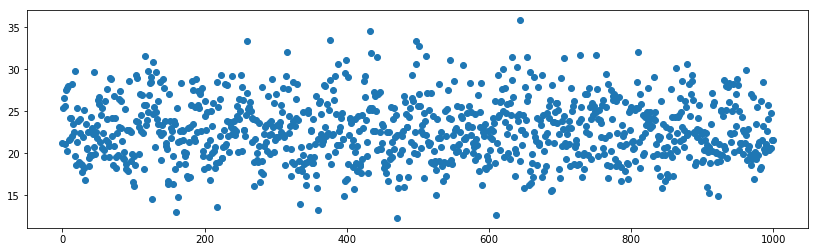

In [103]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [110]:
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))
gds = gds/np.sum(gds)

20947.7369796
20947.947666


In [111]:
#gdd = gradient_descent_dd(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))

20947.9476675
20947.9474798


In [101]:
results = np.array(results)
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

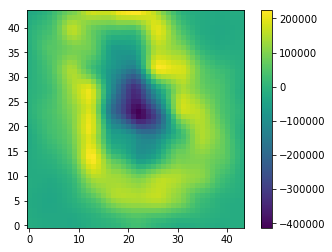

In [113]:
plt.imshow(dlnlike_ds, origin='lower')
plt.colorbar()

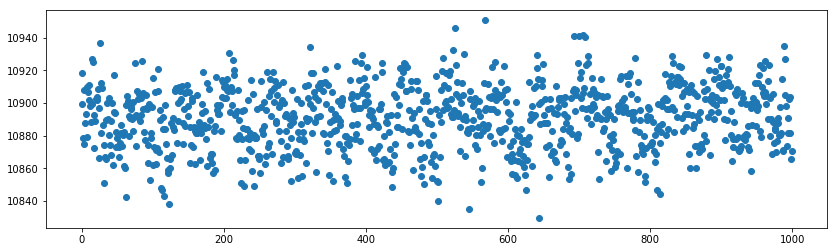

In [104]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), np.log(f_n) * np.sum(np.exp(gds)), 'o')

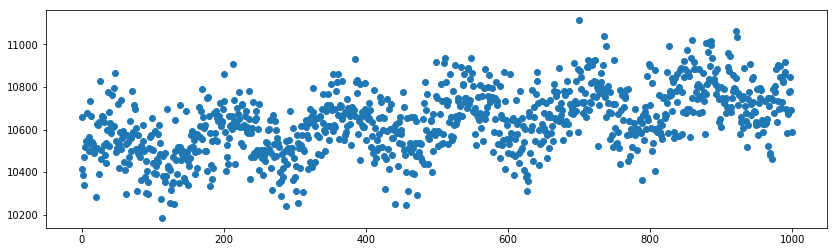

In [105]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), np.sum(tpf_save, axis=(1, 2)), 'o')